In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.insert(0, '..//')

c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\notebooks
c:
Users
sceac10
c:\sceac10\


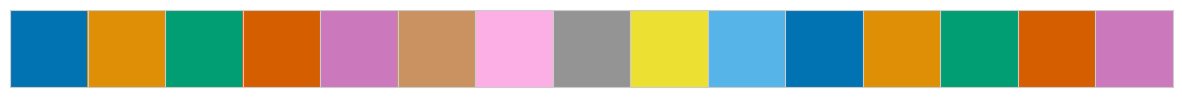

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import sys
from matplotlib.ticker import MaxNLocator
import src.flexibility.thermal_model as tm
import src.flexibility.dwellings_model as dm
import src.flexibility.dwelling_functions as dwelling_functions
import src.flexibility.flexibility_model as fm
import src.utils.utils as utils
from src.utils.folder_system import FolderSystem
import src.visualization.visualize as visualize
from src.flexibility.enums import Method, Keyword, Scenario
import src.dwellings_characteristics.thermal_characteristics as th
from src.flexibility.enums import PowerResolution, TimeResolution, Cunit
import random
from typing import List

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)

ukerc_path_data = r'D:\OneDrive - Cardiff University\04 - Projects\20 - UKERC'
data_org_path = r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Domestic_EPC_results\EPC_thermal_capacity" #computer_path


In [19]:
path_save_paper = r'D:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\02 - communication\FiguresAndTables\\'

In [20]:
# load LSOA data
lsoa_data = pd.read_csv(data_org_path+os.path.sep+'Thermal_characteristics_beforeEE_LSOA_EandW.csv', index_col=0) 
lsoa_data.reset_index(inplace=True)

In [21]:
## fill missing data
constrained_floor_cols = [c for c in lsoa_data.columns if "Average space constrained" in c]
lsoa_data[constrained_floor_cols] = lsoa_data[constrained_floor_cols].fillna(lsoa_data[constrained_floor_cols].mean())

In [22]:
# table of degree days for regions in England and Wales
lsoa_data.groupby("Region").agg({"Degree_days":"mean"})

,Degree_days
Region,
East,1873.6
East Midlands,2055.7
London,1773.5
North East,2216.8
North West,2359.8
South East,1815.7
South West,1740.6
Wales,2058.9
West Midlands,2055.7


In [23]:
# table of design temperature for regions in England and Wales
lsoa_data.groupby("Region").agg({'Design_temperature_degreeC':"mean"})

,Design_temperature_degreeC
Region,
East,-3.0
East Midlands,-3.0
London,-2.0
North East,-5.0
North West,-5.0
South East,-1.0
South West,-2.0
Wales,-3.0
West Midlands,-3.0


## Thermal characteristics of dwellings

In [24]:
## Creation of a tidy dataframe of the original lsoa dataframe

categories = [
            "flat oil boiler",
            "detached gas boiler",
            "detached resistance heating",
            "detached oil boiler",
            "detached biomass boiler",
            "semi-detached gas boiler",
            "semi-detached resistance heating",
            "semi-detached oil boiler",
            "semi-detached biomass boiler",
            "terraced gas boiler",
            "terraced resistance heating",
            "terraced oil boiler",
            "terraced biomass boiler",
            "flat gas boiler",
            "flat resistance heating",
            "flat biomass boiler",
        ]

thermal_capacity_levels = ["low", "medium", "high"]

cols_without_hp = [c for c in lsoa_data.columns if "heat pump" not in c]
tidy_df = th.get_concat_tidy_df(lsoa_data[cols_without_hp], categories, thermal_capacity_levels, "before")
tidy_df = th.add_columns_tidy_df(lsoa_data, tidy_df)
tidy_df.head()


,LSOA_index,Dwelling category,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Percentage of space constrained dwellings,Thermal capacity level,Total annual heat demand kWh,Dwelling forms,Heating systems,Design temperature degreeC,Region,Average size of heating system kW,Total capacity installed of heating systems GW
0,0,flat oil boiler,7760.997724,0.303952,12.0,12937.408384,0.077692,low,155248.900607,flat,oil boiler,-2.0,London,6.990894,0.000084
5,0,semi-detached gas boiler,9761.746787,0.397347,2.0,16912.665792,0.181669,low,33825.331584,semi-detached,gas boiler,-2.0,London,9.138975,0.000018
9,0,terraced gas boiler,17588.048538,0.695063,1.0,29584.664638,0.000000,low,29584.664638,terraced,gas boiler,-2.0,London,15.986451,0.000016
10,0,terraced resistance heating,6526.000000,0.094418,10.0,4018.826439,0.157895,low,40188.264395,terraced,resistance heating,-2.0,London,2.171624,0.000022
13,0,flat gas boiler,5785.363636,0.152747,95.0,6501.515152,0.000000,low,617643.939394,flat,gas boiler,-2.0,London,3.513177,0.000334


In [25]:
results_df = pd.DataFrame(index= tidy_df["Region"].unique(), columns = ["Number of dwellings", "R_K/GW", "C_kJ/K", "HP_Capacity_GW"])
results_df

,Number of dwellings,R_K/GW,C_kJ/K,HP_Capacity_GW
London,NaN,NaN,NaN,NaN
North West,NaN,NaN,NaN,NaN
Yorkshire and The Humber,NaN,NaN,NaN,NaN
North East,NaN,NaN,NaN,NaN
West Midlands,NaN,NaN,NaN,NaN
East Midlands,NaN,NaN,NaN,NaN
South West,NaN,NaN,NaN,NaN
East,NaN,NaN,NaN,NaN
South East,NaN,NaN,NaN,NaN
Wales,NaN,NaN,NaN,NaN


In [26]:
tidy_df

,LSOA_index,Dwelling category,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Percentage of space constrained dwellings,Thermal capacity level,Total annual heat demand kWh,Dwelling forms,Heating systems,Design temperature degreeC,Region,Average size of heating system kW,Total capacity installed of heating systems GW
0,0,flat oil boiler,7760.997724,0.303952,12.0,12937.408384,0.077692,low,1.552489e+05,flat,oil boiler,-2.0,London,6.990894,0.000084
5,0,semi-detached gas boiler,9761.746787,0.397347,2.0,16912.665792,0.181669,low,3.382533e+04,semi-detached,gas boiler,-2.0,London,9.138975,0.000018
9,0,terraced gas boiler,17588.048538,0.695063,1.0,29584.664638,0.000000,low,2.958466e+04,terraced,gas boiler,-2.0,London,15.986451,0.000016
10,0,terraced resistance heating,6526.000000,0.094418,10.0,4018.826439,0.157895,low,4.018826e+04,terraced,resistance heating,-2.0,London,2.171624,0.000022
13,0,flat gas boiler,5785.363636,0.152747,95.0,6501.515152,0.000000,low,6.176439e+05,flat,gas boiler,-2.0,London,3.513177,0.000334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556041,34752,terraced gas boiler,45775.554843,0.373869,107.0,18474.199623,0.108959,high,1.976739e+06,terraced,gas boiler,-3.0,Wales,8.972849,0.000960
556042,34752,terraced resistance heating,39931.500000,0.193215,2.0,9547.432550,0.083333,high,1.909487e+04,terraced,resistance heating,-3.0,Wales,4.637152,0.000009
556045,34752,flat gas boiler,23860.102500,0.160746,370.0,7943.055556,0.050000,high,2.938931e+06,flat,gas boiler,-3.0,Wales,3.857912,0.001427
556046,34752,flat resistance heating,29361.179732,0.046321,411.0,2288.908057,0.035714,high,9.407412e+05,flat,resistance heating,-3.0,Wales,1.111714,0.000457


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9964829111781683 and 23.081178555090812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.215836328500677 and 21.3844572583731


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.5246699360149885 and 17.052871172862428


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.985943637987799 and 8.707465093855948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.4296093235597631 and 16.787803216223715


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.6392732058561688 and 14.640634589928007


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2547433501539702 and 18.330441836713188


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2415247000799365 and 19.331069287993014


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8232582511129023 and 26.723084731018265


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.3852999722053285 and 10.061627585485947


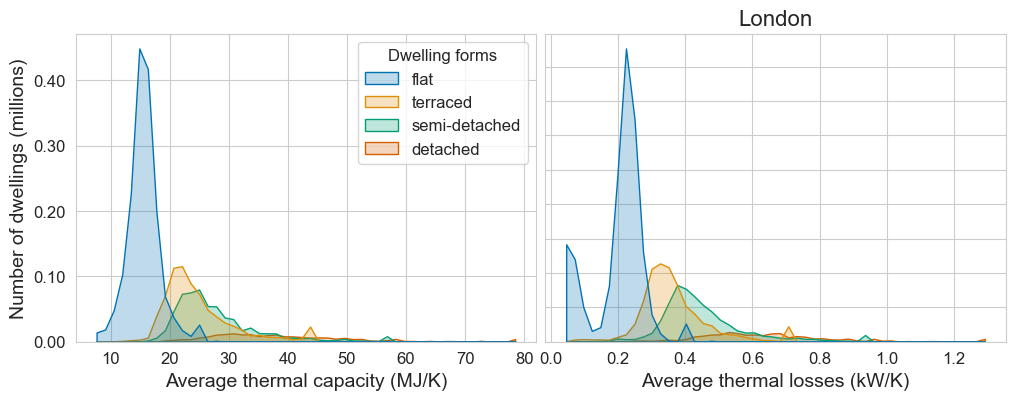

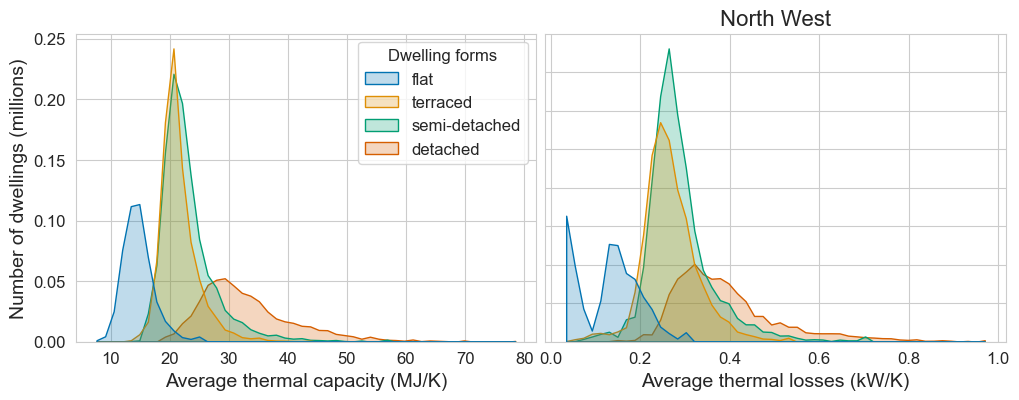

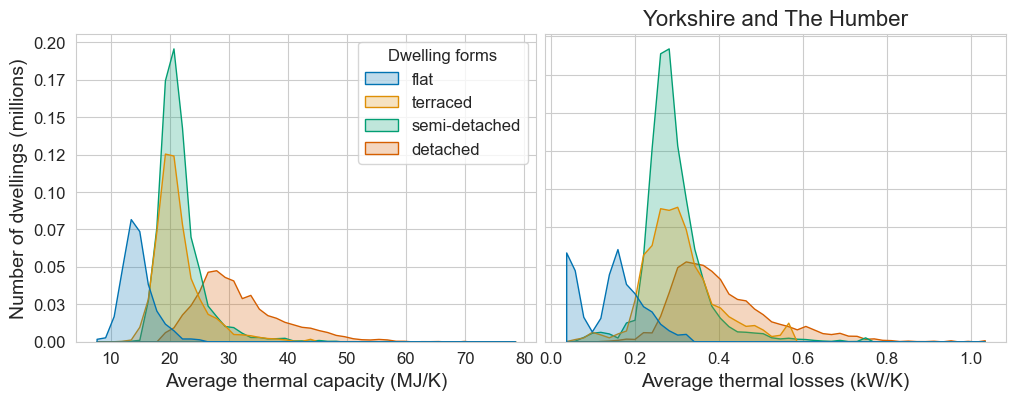

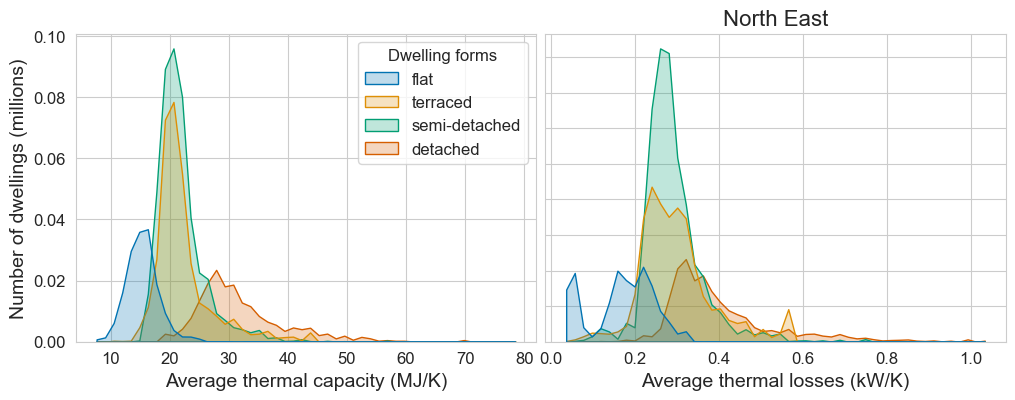

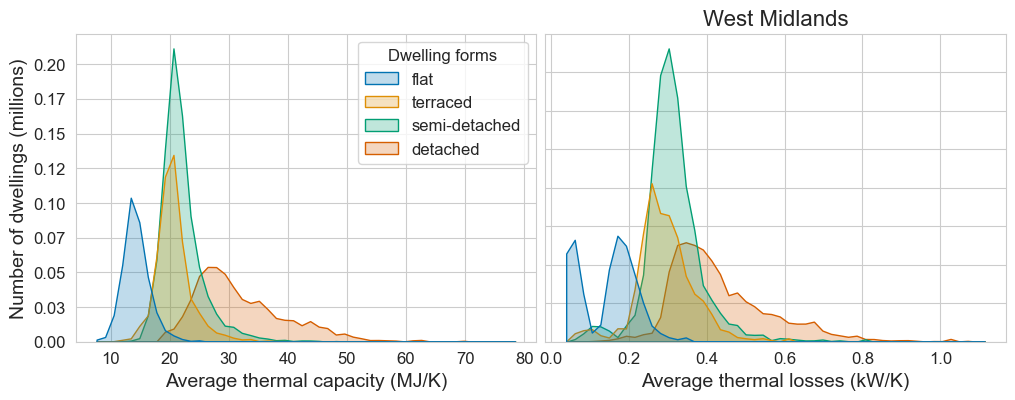

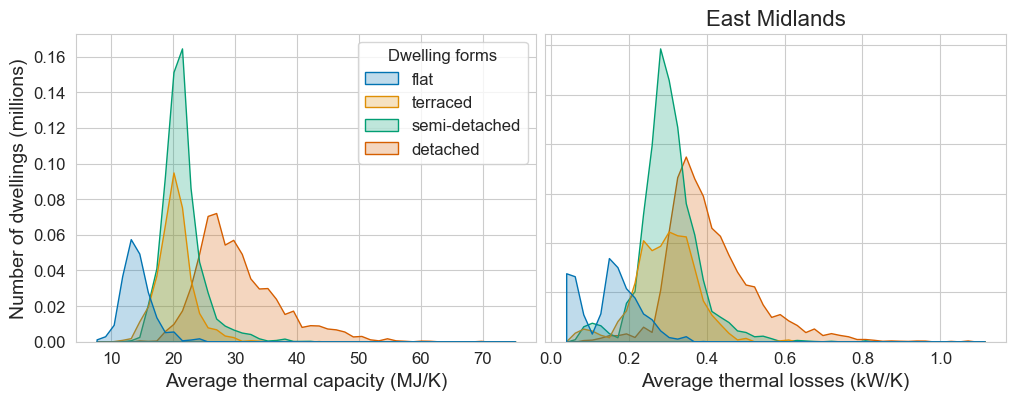

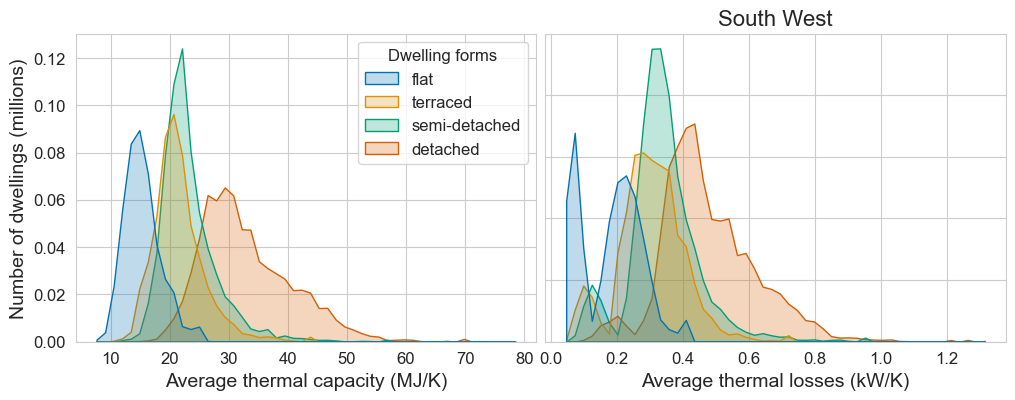

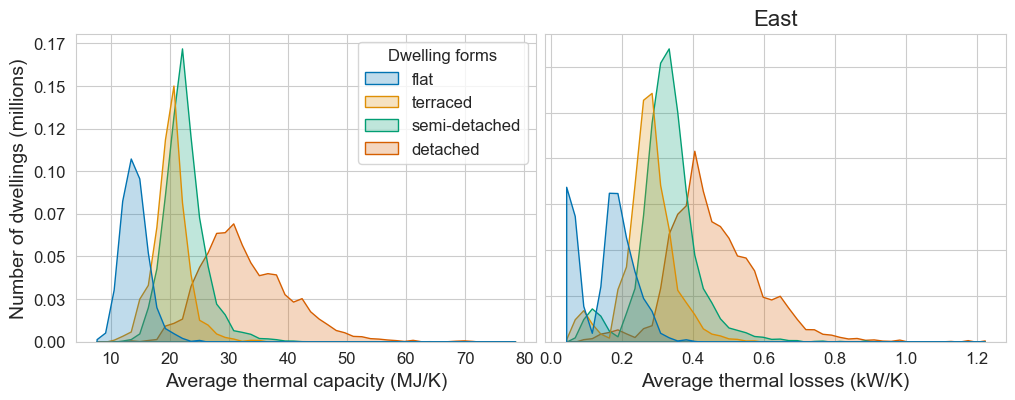

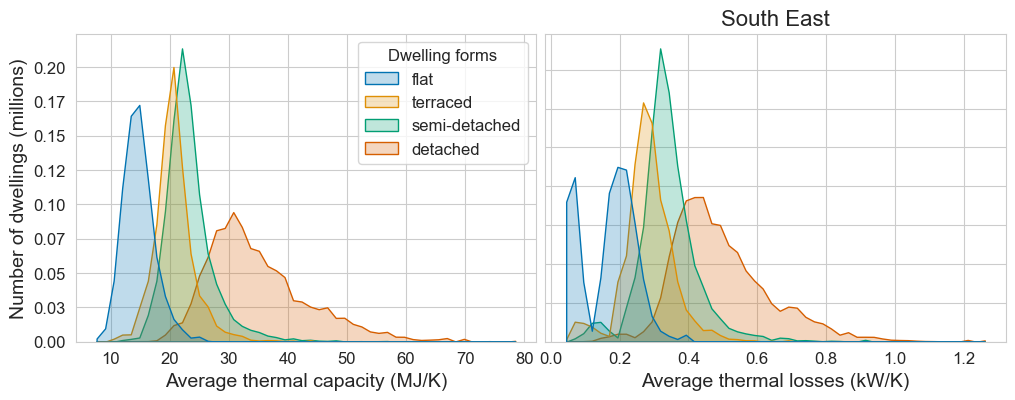

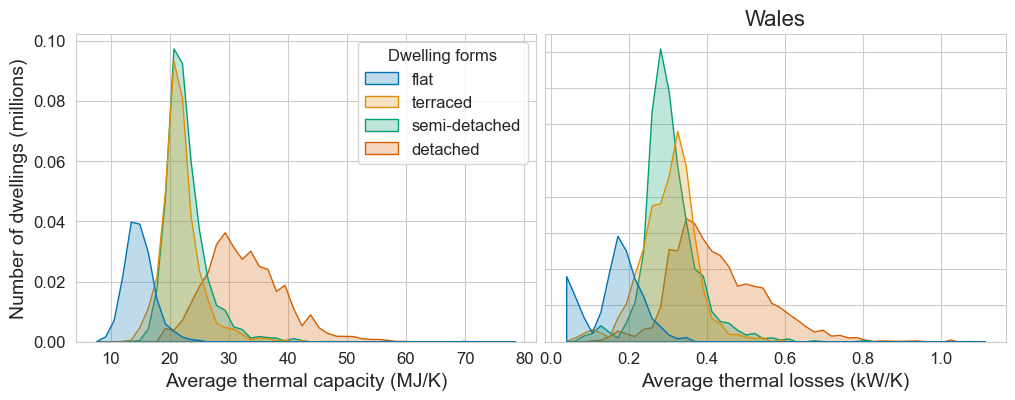

In [27]:
path_qikun = r"D:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\for_qikun"
for region in tidy_df["Region"].unique():
    filt = (tidy_df["Region"] == region) & (tidy_df["Thermal capacity level"]=="medium")
    f,ax = visualize.distribution_thermal_characteristics(tidy_df.loc[filt,:], "medium")
    ax.set_title(f"{region}")
    
    number_dwellings = tidy_df.loc[filt, "Number of dwellings"]
    vd_agg_C = (tidy_df.loc[filt,"Average thermal capacity kJ/K"]*number_dwellings).sum()
    total_HP_Capacity = tidy_df.loc[filt,"Total capacity installed of heating systems GW"].sum()
    design_temperature = tidy_df.loc[filt,"Design temperature degreeC"].mean()
    vd_agg_R = 1 / (total_HP_Capacity/(21-design_temperature)) #K/GW
    print(f"{vd_agg_R} and {total_HP_Capacity}")

    results_df.loc[region, "Number of dwellings"] = number_dwellings.sum()
    results_df.loc[region, "R_K/GW"] = vd_agg_R
    results_df.loc[region, "C_kJ/K"] = vd_agg_C
    results_df.loc[region, "HP_Capacity_GW"] = total_HP_Capacity
    f.savefig(path_qikun+os.path.sep+f"{region}_figure."+export_fig_format, bbox_inches='tight', format=export_fig_format, dpi=dpi)


results_df.to_csv(path_qikun+os.path.sep+"region_data.csv")

In [28]:
results_df

,Number of dwellings,R_K/GW,C_kJ/K,HP_Capacity_GW
London,3195777.0,0.996483,68870280066.203445,23.081179
North West,2988477.0,1.215836,69195158928.904068,21.384457
Yorkshire and The Humber,2193853.0,1.52467,50000424050.064758,17.052871
North East,1144512.0,2.985944,25946921529.43993,8.707465
West Midlands,2242157.0,1.429609,51506111616.392738,16.787803
East Midlands,1911291.0,1.639273,44745394825.025131,14.640635
South West,2320904.0,1.254743,56445491947.615082,18.330442
East,2474026.0,1.241525,58554880982.854507,19.331069
South East,3620071.0,0.823258,87920766452.049454,26.723085
Wales,1312141.0,2.3853,31783107311.423229,10.061628


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1200x400 with 2 Axes>,
 <AxesSubplot: xlabel='Average thermal losses (kW/K)'>)

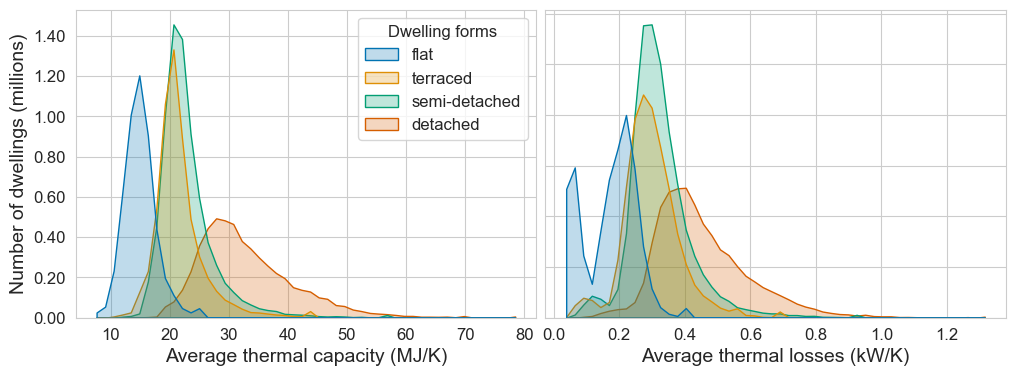

In [29]:
visualize.distribution_thermal_characteristics(tidy_df, "medium")

In [30]:
tidy_df.loc[tidy_df["Thermal capacity level"]=="medium"].groupby(["Dwelling forms", "Average thermal capacity kJ/K", "Average thermal losses kW/K"]).agg({"Number of dwellings":["sum"]}).to_csv(path_save_paper+os.path.sep+"data for Qikun.csv")

In [31]:
tidy_df

,LSOA_index,Dwelling category,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Percentage of space constrained dwellings,Thermal capacity level,Total annual heat demand kWh,Dwelling forms,Heating systems,Design temperature degreeC,Region,Average size of heating system kW,Total capacity installed of heating systems GW
0,0,flat oil boiler,7760.997724,0.303952,12.0,12937.408384,0.077692,low,1.552489e+05,flat,oil boiler,-2.0,London,6.990894,0.000084
5,0,semi-detached gas boiler,9761.746787,0.397347,2.0,16912.665792,0.181669,low,3.382533e+04,semi-detached,gas boiler,-2.0,London,9.138975,0.000018
9,0,terraced gas boiler,17588.048538,0.695063,1.0,29584.664638,0.000000,low,2.958466e+04,terraced,gas boiler,-2.0,London,15.986451,0.000016
10,0,terraced resistance heating,6526.000000,0.094418,10.0,4018.826439,0.157895,low,4.018826e+04,terraced,resistance heating,-2.0,London,2.171624,0.000022
13,0,flat gas boiler,5785.363636,0.152747,95.0,6501.515152,0.000000,low,6.176439e+05,flat,gas boiler,-2.0,London,3.513177,0.000334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556041,34752,terraced gas boiler,45775.554843,0.373869,107.0,18474.199623,0.108959,high,1.976739e+06,terraced,gas boiler,-3.0,Wales,8.972849,0.000960
556042,34752,terraced resistance heating,39931.500000,0.193215,2.0,9547.432550,0.083333,high,1.909487e+04,terraced,resistance heating,-3.0,Wales,4.637152,0.000009
556045,34752,flat gas boiler,23860.102500,0.160746,370.0,7943.055556,0.050000,high,2.938931e+06,flat,gas boiler,-3.0,Wales,3.857912,0.001427
556046,34752,flat resistance heating,29361.179732,0.046321,411.0,2288.908057,0.035714,high,9.407412e+05,flat,resistance heating,-3.0,Wales,1.111714,0.000457


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1200x400 with 2 Axes>,
 <AxesSubplot: xlabel='Average thermal losses (kW/K)'>)

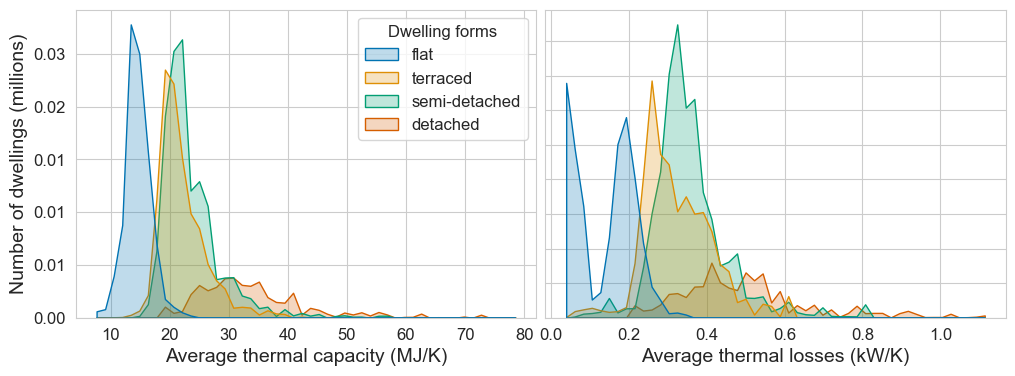

In [32]:
list_LA_index = lsoa_data.loc[lsoa_data["Local Authority"] == "Birmingham", "index"].values

visualize.distribution_thermal_characteristics(tidy_df.loc[tidy_df["LSOA_index"].isin(list_LA_index)], "medium")

## Thermal characteristics per dwellings category

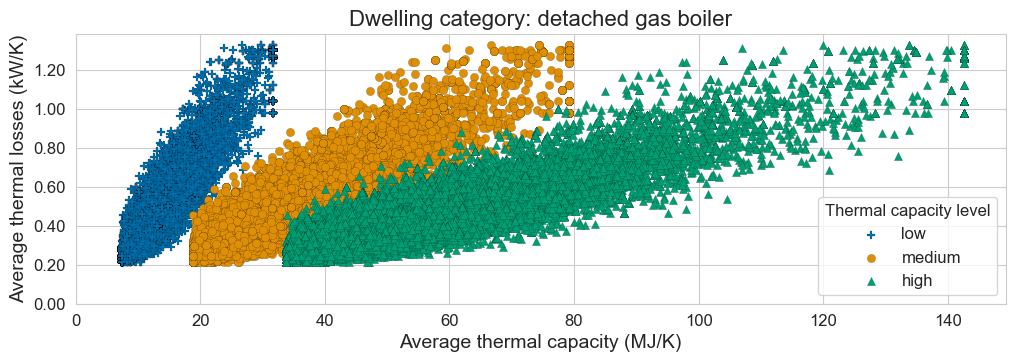

In [33]:
categories = [  
                'detached gas boiler',
                # 'detached resistance heating',
                # 'detached oil boiler',
                # 'detached biomass boiler',
                # 'semi-detached gas boiler', 
                # 'semi-detached resistance heating',
                # 'semi-detached oil boiler',
                # 'semi-detached biomass boiler',
                # 'terraced gas boiler',
                # 'terraced resistance heating',
                # 'terraced oil boiler',
                # 'terraced biomass boiler',
                # 'flat oil boiler',
                # 'flat gas boiler',
                # 'flat resistance heating',
                # 'flat biomass boiler'
             ]

for c in categories:
    filters = (tidy_df["Dwelling category"] == c)
    f, ax = visualize.plot_thermal_characteristics_dwelling_category(tidy_df.loc[filters], thermal_capacity_levels, c)
    f.savefig(path_save_paper+os.path.sep+"figure_."+export_fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)
    f.savefig(path_save_paper+os.path.sep+"figure_."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

## Thermal characteristics per LSOA

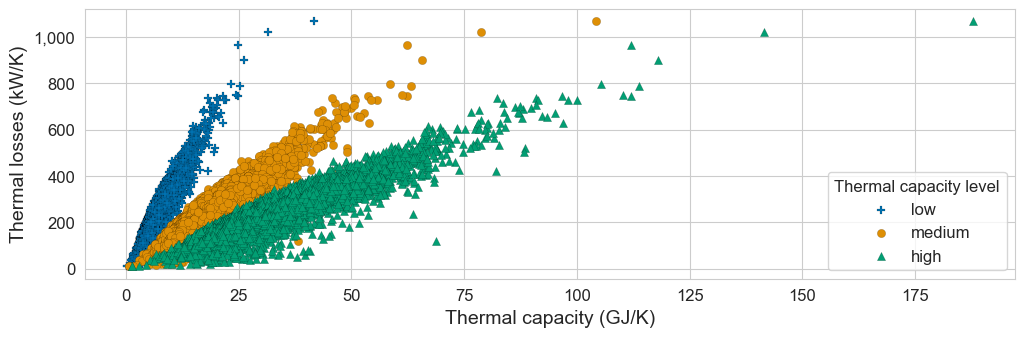

In [34]:
f, ax = visualize.plot_thermal_characteristics_lsoa_level(lsoa_data, thermal_capacity_levels)
f.savefig(path_save_paper+os.path.sep+"figure_."+export_fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)
f.savefig(path_save_paper+os.path.sep+"figure_."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

## Number of dwellings and residential heating demand in England and Wales

In [35]:
categories = [
            "flat oil boiler",
            "detached gas boiler",
            "detached resistance heating",
            "detached oil boiler",
            "detached biomass boiler",
            "semi-detached gas boiler",
            "semi-detached resistance heating",
            "semi-detached oil boiler",
            "semi-detached biomass boiler",
            "terraced gas boiler",
            "terraced resistance heating",
            "terraced oil boiler",
            "terraced biomass boiler",
            "flat gas boiler",
            "flat resistance heating",
            "flat biomass boiler",
        ]

for factor in [0.5, 0.75, 1]:
    total_dwellings = 0
    for lsoa_index in lsoa_data.index:
        for cat in categories:
            number_col = f"Number of {cat} in 2018"
            nb_val = int(round(lsoa_data.loc[lsoa_index, number_col]*factor, 0))
            total_dwellings += nb_val
    print(total_dwellings)

11681273
17573454
23403209


In [36]:
temp_tidy_df = tidy_df.loc[tidy_df["Thermal capacity level"]=="medium", :]
dwelling_forms = ["detached", "semi-detached", "terraced", "flat"]
heating_systems = ["gas boiler", "resistance heating", "oil boiler", "biomass boiler"]

Heating systems
gas boiler            0.854577
resistance heating    0.091604
oil boiler            0.045709
biomass boiler        0.008110
dtype: float64
Dwelling forms
detached         0.231211
semi-detached    0.314058
terraced         0.244317
flat             0.210414
dtype: float64


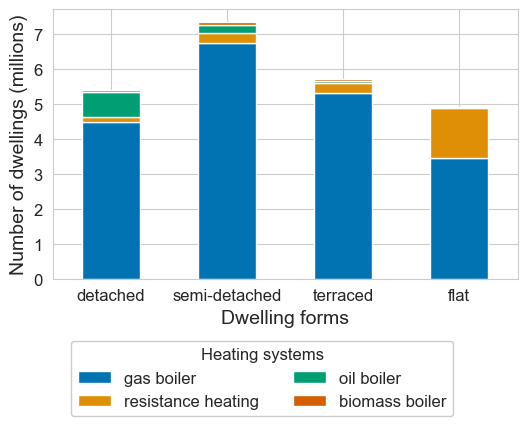

In [37]:
df_to_plot = temp_tidy_df.groupby(["Dwelling forms", "Heating systems"]).agg({"Number of dwellings": "sum"}).reset_index()
df_to_plot = df_to_plot.pivot(index="Dwelling forms", columns="Heating systems", values="Number of dwellings")
df_to_plot = df_to_plot.loc[dwelling_forms, heating_systems]
f, ax = visualize.plot_bar_chart(df_to_plot, 1_000_000, stacked=True)
ax.set_ylabel("Number of dwellings (millions)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(facecolor="white", framealpha=1, frameon=True, title="Heating systems",ncol=2,bbox_to_anchor=(0.88, -0.2),)
print(df_to_plot.sum()/df_to_plot.sum().sum())
print(df_to_plot.sum(axis=1)/df_to_plot.sum(axis=1).sum())

Total capacity installed of heating systems GW    176.100633
dtype: float64

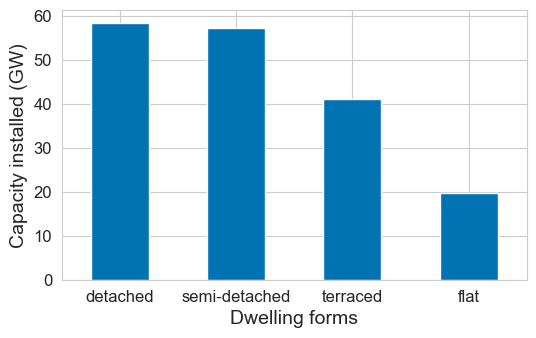

In [38]:
df_to_plot = temp_tidy_df.groupby("Dwelling forms").agg({"Total capacity installed of heating systems GW": "sum"})
f, ax = visualize.plot_bar_chart(df_to_plot.loc[dwelling_forms, :], 1)
ax.set_ylabel("Capacity installed (GW)")
df_to_plot.sum()

## Indoor air temperature

(<Figure size 1200x350 with 1 Axes>,
 <AxesSubplot: xlabel='Indoor air temperature (ºC)', ylabel='Probability density'>)

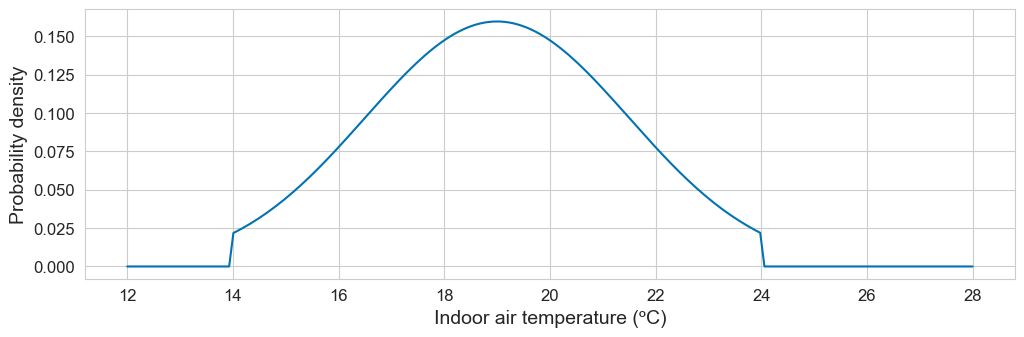

In [39]:
## shows probability density function inside air temperature
visualize.plot_probability_function(dwelling_functions.truncated_normal)

In [40]:
# probability of a dwelling being assigned a temperature below 18C
lower_temperature_threshold=18
mean_indoor_temperature=19
std_indoor_temperature=2.5
min_observed_indoor_temperature=14
max_observed_indoor_temperature=24

dwelling_functions.cfd_truncated_normal(lower_temperature_threshold,
        mean_indoor_temperature,
        std_indoor_temperature,
        min_observed_indoor_temperature,
        max_observed_indoor_temperature,)


0.33716942422135127

## Comparison of individual dwellings model and representative dwellings model on a single LSOA

c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\notebooks\..\src\flexibility\dwellings_model.py:494: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  


[968.22339626 887.90045981 887.90045981 ...   1.67881551   1.67881551
   1.67881551] [968.22339626 887.90045981 887.90045981 ...   1.67881551   1.67881551
   1.67881551]
[968.22339626 887.90045981 887.90045981 ...   1.67881551   1.67881551
   1.67881551] [968.22339626 887.90045981 887.90045981 ...   1.67881551   1.67881551
   1.67881551]


c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\notebooks\..\src\flexibility\dwellings_model.py:494: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  


(<Figure size 1200x350 with 1 Axes>,
 <AxesSubplot: xlabel='Duration (s)', ylabel='Flexibility provided (MW)'>)

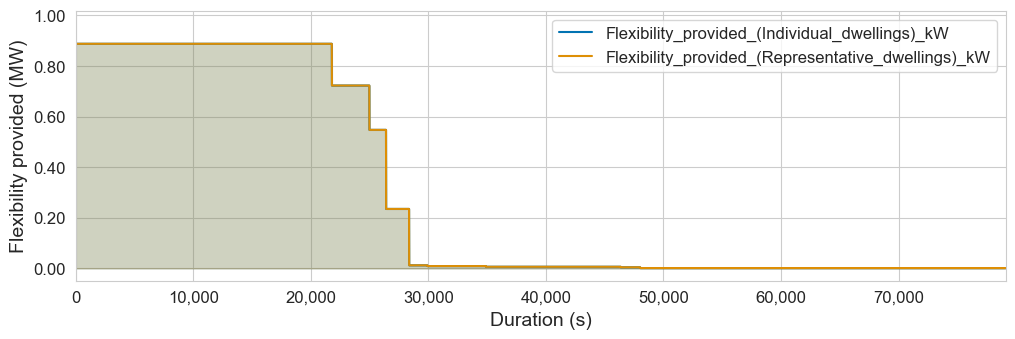

In [41]:
capacity_factor = 1
nb_cluster = 100
xaxis_resolution = 'min'
yaxis_resolution = 'MW'
demand_increase = True # default assumption
OAT = 10
index_lsoa= [3495]
max_index = 60*1000

# default temperature for a stock of dwellings during the heating season. Around 33 to 40% of the dwellings are below the threshold of 18C.

(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_mean_inside_air_temperature_func(
    capacity_factor,
)

# R_func = lambda x: np.random.normal(x, np.abs(x*0/100))
# C_func = lambda x: np.random.normal(x, np.abs(x*0/100))

flex_obj = (dm.Dwellings(index_lsoa, T_limit, capacity_factor, demand_increase, outside_air_temperature=OAT)
            .create_dwellings(lsoa_data)
            .add_variables(temperature_func)
            .get_duration_service(dm.Method.INDIVIDUAL)
            .cluster_dwellings(380)
            .create_representative_dwellings_df(key=dm.Keyword.SUM)
            .get_duration_service(dm.Method.REPRESENTATIVE)
            .concat_results()
)
flex_obj.calculate_scores()
visualize.plot_flexibility_results(flex_obj.concat_results_df)

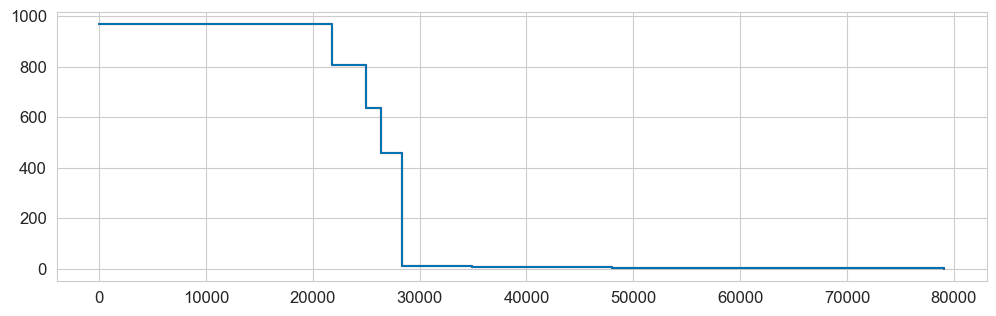

In [42]:
f, ax = plt.subplots(figsize=figsize)
agg_df = flex_obj.summary_representative_dwellings
x_arr = agg_df.index.values
y_arr = agg_df['Flexibility_provided_kW'].values
ax.plot(x_arr, y_arr, color='red')

agg_df = flex_obj.summary_individual_dwellings
x_arr = agg_df.index.values
y_arr = agg_df['Flexibility_provided_kW'].values
ax.plot(x_arr, y_arr)

# Running the model on multiple LSOAs

c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\notebooks\..\src\flexibility\dwellings_model.py:494: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  


(<Figure size 1200x350 with 1 Axes>,
 <AxesSubplot: xlabel='Duration (s)', ylabel='Flexibility provided (MW)'>)

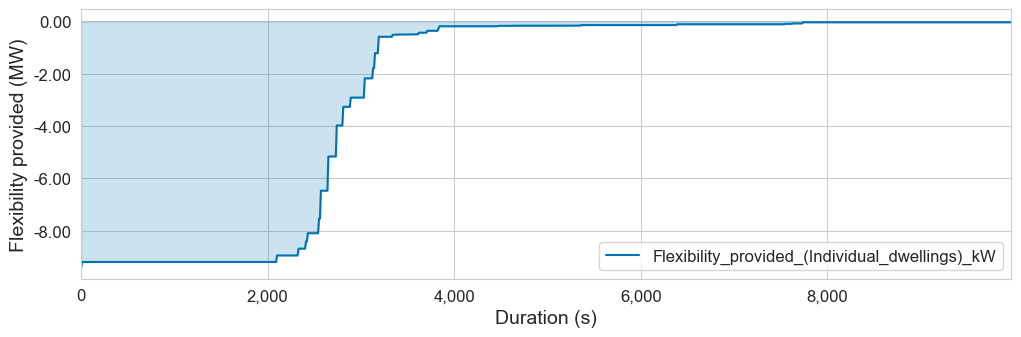

In [43]:
capacity_factor = 0
nb_cluster = 100
xaxis_resolution = 'min'
yaxis_resolution = 'MW'
demand_increase = True # default assumption
index_lsoa= [3495, 1500, 2000, 4642]
max_index = 60*1000
OAT = -5
# default temperature for a stock of dwellings during the heating season. Around 33 to 40% of the dwellings are below the threshold of 18C.

(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_mean_inside_air_temperature_func(
    capacity_factor,mean_indoor_temperature=19
)

# R_func = lambda x: np.random.normal(x, np.abs(x*0/100))
# C_func = lambda x: np.random.normal(x, np.abs(x*0/100))

flex_obj = (dm.Dwellings(index_lsoa, T_limit, capacity_factor, demand_increase, outside_air_temperature=OAT)
            .create_dwellings(lsoa_data)
            .add_variables(temperature_func)
            .get_duration_service(dm.Method.INDIVIDUAL)
            .concat_results()
)
# flex_obj.calculate_scores()
visualize.plot_flexibility_results(flex_obj.concat_results_df)

In [44]:
flex_obj.dwellings_df

,LSOA,Dwelling_category,C_kJ/K,R_K/kW,Design_temperature_ºC,Initial_indoor_temperature_ºC,Outdoor_temperature_ºC,Final_indoor_temperature_ºC,Capacity_factor_%,Cluster,Flexibility_provided_kW,Initial_heating_outputk_kW,Max_heating_output_kW
Index,,,,,,,,,,,,,
0,E01003572,detached gas boiler,42057.692308,1.173149,-2.0,19,-5,18,0,0,-9.802677,19.605353,19.605353
1,E01003572,detached gas boiler,42057.692308,1.173149,-2.0,19,-5,18,0,0,-9.802677,19.605353,19.605353
2,E01003572,detached gas boiler,42057.692308,1.173149,-2.0,19,-5,18,0,0,-9.802677,19.605353,19.605353
3,E01003572,detached gas boiler,42057.692308,1.173149,-2.0,19,-5,18,0,0,-9.802677,19.605353,19.605353
4,E01003572,detached gas boiler,42057.692308,1.173149,-2.0,19,-5,18,0,0,-9.802677,19.605353,19.605353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,E01004766,flat resistance heating,13920.192308,16.832512,-5.0,19,-5,18,0,0,-0.712906,1.425812,1.544630
2314,E01004766,flat resistance heating,13920.192308,16.832512,-5.0,19,-5,18,0,0,-0.712906,1.425812,1.544630
2315,E01004766,flat resistance heating,13920.192308,16.832512,-5.0,19,-5,18,0,0,-0.712906,1.425812,1.544630


# Results for England and Wales

In [45]:
# parameters plots
max_duration = 80000
time_resolution = TimeResolution.HOURS
power_resolution = PowerResolution.GIGAWATT

In [46]:
scenario = Scenario.HP100
use_pdf = False
mean_IAT = 19 
after_EE = False
thermal_capacity_level = "medium"
OAT = 5

capacity_factor=1
positive_flexibility_LA_df = visualize.get_results_data(scenario=Scenario.HP100, 
                    use_pdf=use_pdf, 
                    mean_indoor_temperature=mean_IAT, 
                    after_EE=after_EE, 
                    thermal_capacity_level=thermal_capacity_level,
                    outside_air_temperature=OAT,
                    capacity_factor=capacity_factor)


positive_flexibility_LA_df = visualize.get_min_max_flexibility_results(positive_flexibility_LA_df, capacity_factor)

capacity_factor=0
negative_flexibility_LA_df = visualize.get_results_data(scenario=Scenario.HP100, 
                    use_pdf=use_pdf, 
                    mean_indoor_temperature=mean_IAT, 
                    after_EE=after_EE, 
                    thermal_capacity_level=thermal_capacity_level,
                    outside_air_temperature=OAT,
                    capacity_factor=capacity_factor)

negative_flexibility_LA_df = visualize.get_min_max_flexibility_results(negative_flexibility_LA_df, capacity_factor)

min_flexibility = int(negative_flexibility_LA_df["Flexibility_MW"].min())
max_flexibility = int(positive_flexibility_LA_df["Flexibility_MW"].max())

UnboundLocalError: local variable 'folder_system' referenced before assignment

c:\Users\sceac10\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\Users\sceac10\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


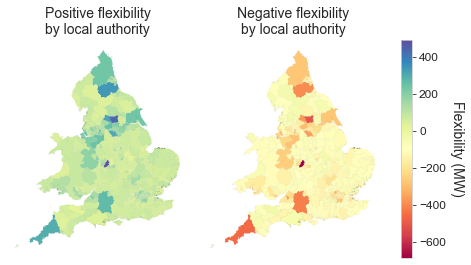

In [ ]:
path_map =  r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\GIS map and data"
file = "Local_authority_UK_2019.geojson"
path_map = path_map+os.path.sep+file

fig, axs = plt.subplots(1, 2, figsize=(figsize[0],round(figsize[1])) )
plt.subplots_adjust(wspace=-0.5, hspace=0)
cmap_1 = 'Spectral'

ax = axs[0]
cbar = visualize.create_map_LA(positive_flexibility_LA_df , "Flexibility_MW", path_map, fig, ax,min_flexibility, max_flexibility,  cmap=cmap_1)
cbar.remove()
ax.set_title("Positive flexibility\nby local authority", fontsize= font_size+2)
ax= axs[1]
cbar = visualize.create_map_LA(negative_flexibility_LA_df , "Flexibility_MW", path_map, fig, ax, min_flexibility, max_flexibility,  cmap=cmap_1)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Flexibility (MW)', rotation=270)
ax.set_title("Negative flexibility\nby local authority", fontsize= font_size+2)

fig

In [ ]:
negative_flexibility_LA_df.loc[negative_flexibility_LA_df["Local_authority"] == "Cornwall"]

,Local_authority,Flexibility_kW,Local Authority (2019),Flexibility_MW
71,Cornwall,-457190.72873,Cornwall,-457.190729


Looking for results files in: None
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_0_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_1_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_2_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_3_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\2

min_          max_
Capacity_factor Outside_air_temperature_ºC                            
0               -5                         -8.623706e+07 -9.645935e+00
                 0                         -6.082202e+07 -6.640318e+00
                 5                         -4.294889e+07 -4.688996e+00
                 10                        -2.548615e+07 -2.782481e+00
1               -5                          9.066306e+05  1.813261e+06
                 0                          2.446433e+00  1.574347e+07
                 5                          1.669191e+01  3.042638e+07
                 10                         1.081354e+00  4.224486e+07

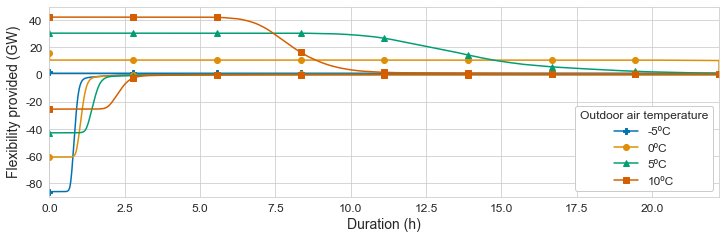

In [ ]:
scenario = Scenario.HP100
use_pdf = False
mean_IAT = 19 
after_EE = False
thermal_capacity_level = "medium"
filter_variables = ["Outside_air_temperature_ºC", "Capacity_factor"]
hue = "Outside_air_temperature_ºC"
EW_df = visualize.get_concat_results(scenario=Scenario.HP100, use_pdf=use_pdf, mean_indoor_temperature=mean_IAT, after_EE=after_EE, thermal_capacity_level=thermal_capacity_level)
to_plot_df = EW_df.loc[EW_df.index<max_duration]
f, ax = plt.subplots(figsize=figsize)
ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)
legend_dict = visualize.get_legend_parameters(ax, Cunit.OAT)
ax.legend(**legend_dict)
ax.set_ylim(-90, 50)
EW_df.groupby(["Capacity_factor", "Outside_air_temperature_ºC"]).agg(min_ = ("Flexibility_kW","min"), max_ = ("Flexibility_kW","max"))

24341104.0

Looking for results files in: None
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_20_thermal_capacity_medium\Results_slice_0_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_20_thermal_capacity_medium\Results_slice_1_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_20_thermal_capacity_medium\Results_slice_2_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_mean_temp_20_thermal_capacity_medium\Results_slice_3_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\2

min_          max_
Capacity_factor Outside_air_temperature_ºC                            
0               -5                         -8.714369e+07 -1.004785e+01
                 0                         -6.402318e+07 -6.989808e+00
                 5                         -4.601666e+07 -5.023924e+00
                 10                        -2.831795e+07 -3.091646e+00
1               -5                          4.533153e+05  9.066306e+05
                 0                          2.096942e+00  1.254231e+07
                 5                          1.460542e+01  2.735860e+07
                 10                         1.009264e+00  3.941307e+07

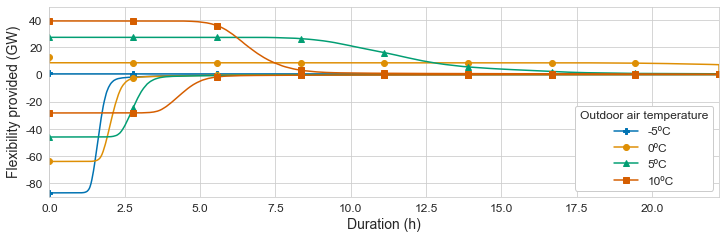

In [ ]:
scenario = Scenario.HP100
use_pdf = False
mean_IAT = 20
after_EE = False
thermal_capacity_level = "medium"
filter_variables = ["Outside_air_temperature_ºC", "Capacity_factor"]
hue = "Outside_air_temperature_ºC"
EW_df = visualize.get_concat_results(scenario=Scenario.HP100, use_pdf=use_pdf, mean_indoor_temperature=mean_IAT, after_EE=after_EE, thermal_capacity_level=thermal_capacity_level)
to_plot_df = EW_df.loc[EW_df.index<max_duration]
f, ax = plt.subplots(figsize=figsize)
ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)
legend_dict = visualize.get_legend_parameters(ax, Cunit.OAT)
ax.legend(**legend_dict)
ax.set_ylim(-90, 50)
EW_df.groupby(["Capacity_factor", "Outside_air_temperature_ºC"]).agg(min_ = ("Flexibility_kW","min"), max_ = ("Flexibility_kW","max"))

Looking for results files in: None
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_pdf_temp_thermal_capacity_medium\Results_slice_0_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_pdf_temp_thermal_capacity_medium\Results_slice_1_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_pdf_temp_thermal_capacity_medium\Results_slice_2_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\before_energy_efficiency\OAT_-5_pdf_temp_thermal_capacity_medium\Results_slice_3_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - C

min_          max_
Capacity_factor Outside_air_temperature_ºC                            
0               -5                         -5.805531e+07 -1.899957e-01
                 0                         -4.325033e+07 -1.516266e-01
                 5                         -3.132664e+07 -1.135145e-01
                 10                        -1.950793e+07 -6.683405e-02
1               -5                          1.864721e+06  3.729442e+06
                 0                          7.590495e-02  1.579481e+07
                 5                          1.081619e-01  3.042786e+07
                 10                         1.380349e-01  4.224701e+07

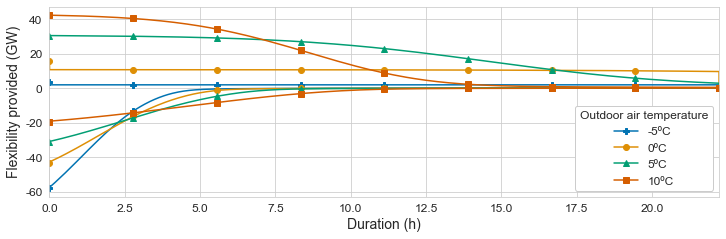

In [ ]:
scenario = Scenario.HP100
use_pdf = True
mean_IAT = 19 
after_EE = False
thermal_capacity_level = "medium"
filter_variables = ["Outside_air_temperature_ºC", "Capacity_factor"]
hue = "Outside_air_temperature_ºC"
EW_df = visualize.get_concat_results(scenario=Scenario.HP100, use_pdf=use_pdf, mean_indoor_temperature=mean_IAT, after_EE=after_EE, thermal_capacity_level=thermal_capacity_level)
to_plot_df = EW_df.loc[EW_df.index<max_duration]
f, ax = plt.subplots(figsize=figsize)
ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)
legend_dict = visualize.get_legend_parameters(ax, Cunit.OAT)
ax.legend(**legend_dict)
EW_df.groupby(["Capacity_factor", "Outside_air_temperature_ºC"]).agg(min_ = ("Flexibility_kW","min"), max_ = ("Flexibility_kW","max"))

## Results using annual heat demand after energy efficiency measures

In [ ]:
# load LSOA data
lsoa_data_after_EE = pd.read_csv(data_org_path+os.path.sep+'Thermal_characteristics_afterEE_LSOA_EandW.csv', index_col=0) 
lsoa_data_after_EE.reset_index(inplace=True)

In [ ]:
## Creation of a tidy dataframe of the original lsoa dataframe

categories = [
            "flat oil boiler",
            "detached gas boiler",
            "detached resistance heating",
            "detached oil boiler",
            "detached biomass boiler",
            "semi-detached gas boiler",
            "semi-detached resistance heating",
            "semi-detached oil boiler",
            "semi-detached biomass boiler",
            "terraced gas boiler",
            "terraced resistance heating",
            "terraced oil boiler",
            "terraced biomass boiler",
            "flat gas boiler",
            "flat resistance heating",
            "flat biomass boiler",
        ]

thermal_capacity_levels = ["low", "medium", "high", "medium+10%", "medium-10%"]

cols_without_hp = [c for c in lsoa_data_after_EE.columns if "heat pump" not in c]
tidy_after_EE_df = th.get_concat_tidy_df(lsoa_data_after_EE[cols_without_hp], categories, thermal_capacity_levels, "after")
tidy_after_EE_df = th.add_columns_tidy_df(lsoa_data_after_EE, tidy_after_EE_df)
tidy_after_EE_df.head()


,LSOA_index,Dwelling category,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Percentage of space constrained dwellings,Thermal capacity level,Total annual heat demand kWh,Dwelling forms,Heating systems,Design temperature degreeC,Region,Average size of heating system kW,Total capacity installed of heating systems GW
5,0,flat gas boiler,5785.363636,0.114664,95.0,4880.555556,0.000000,low,4.636528e+05,flat,gas boiler,-2.0,London,2.637270,0.000251
6,0,flat oil boiler,7743.573923,0.190661,12.0,8115.289346,NaN,low,9.738347e+04,flat,oil boiler,-2.0,London,4.385200,0.000053
7,0,flat resistance heating,6430.371429,0.044127,680.0,1878.217083,0.028571,low,1.277188e+06,flat,resistance heating,-2.0,London,1.014919,0.000690
9,0,semi-detached gas boiler,9757.884426,0.262593,2.0,11176.994057,NaN,low,2.235399e+04,semi-detached,gas boiler,-2.0,London,6.039631,0.000012
13,0,terraced gas boiler,17584.164375,0.436325,1.0,18571.754902,0.000000,low,1.857175e+04,terraced,gas boiler,-2.0,London,10.035485,0.000010


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='Average thermal losses (kW/K)'>)

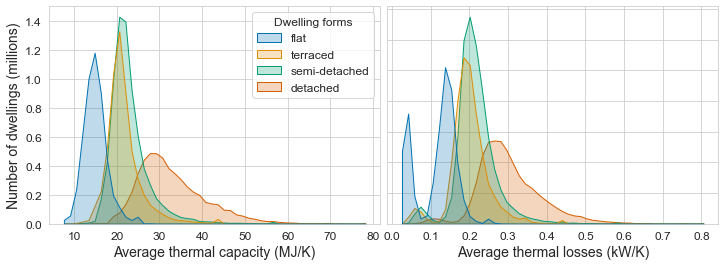

In [ ]:
visualize.distribution_thermal_characteristics(tidy_after_EE_df, "medium")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='Average thermal losses (kW/K)'>)

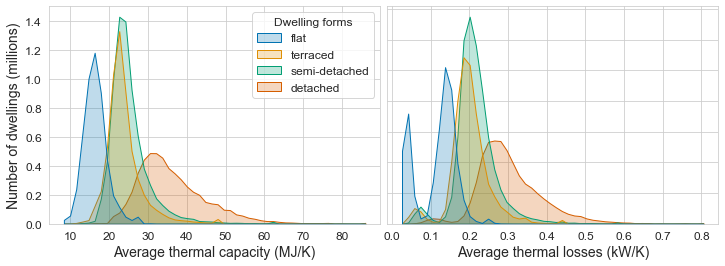

In [ ]:
visualize.distribution_thermal_characteristics(tidy_after_EE_df, "medium+10%")

In [ ]:
lines, labels = ax.get_legend_handles_labels()
labels

['-5']

Looking for results files in: None
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\after_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_0_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\after_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_1_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\after_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_2_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\results_modelling_EW\after_energy_efficiency\OAT_-5_mean_temp_19_thermal_capacity_medium\Results_slice_3_cf_0_sc_HP100.csv
Opening: d:\OneDrive - Cardiff University\04 - Projects\20 - 

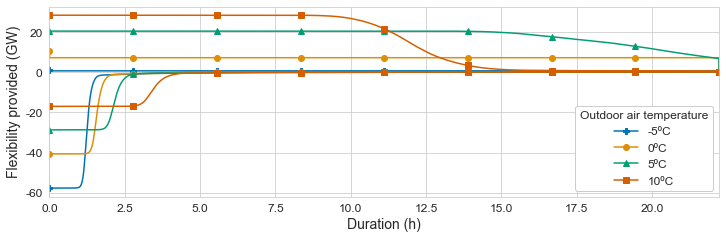

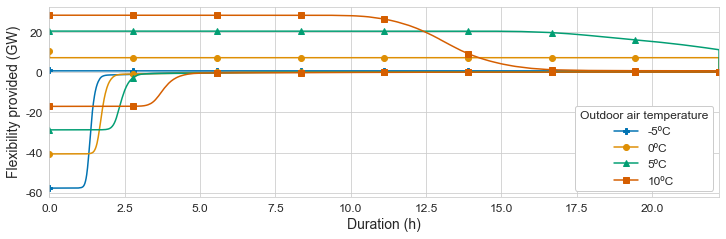

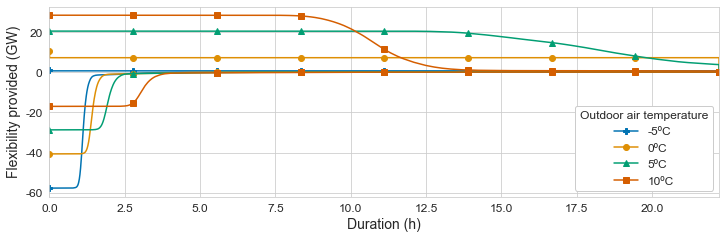

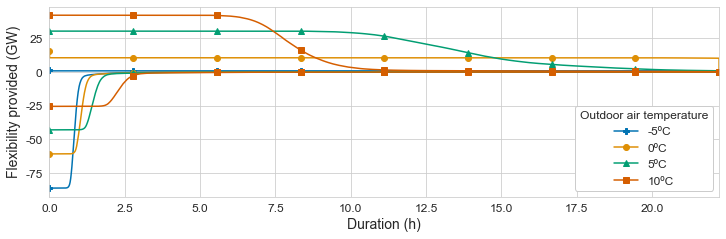

In [ ]:
max_duration = 80000
scenario = Scenario.HP100
use_pdf = False
mean_IAT = 19
after_EE = True
filter_variables = ["Outside_air_temperature_ºC", "Capacity_factor"]
hue = "Outside_air_temperature_ºC"
frames = []
for after_EE in [True, False]:
    for thermal_capacity_level in ["medium", "medium+10%", "medium-10%"]:
        EW_df = visualize.get_concat_results(scenario=Scenario.HP100, use_pdf=use_pdf, mean_indoor_temperature=mean_IAT, after_EE=after_EE, thermal_capacity_level=thermal_capacity_level)
        if len(EW_df)>0:
            to_plot_df = EW_df.loc[EW_df.index<max_duration].copy()
            f, ax = plt.subplots(figsize=figsize)
            ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)

            legend_dict = visualize.get_legend_parameters(ax, Cunit.OAT)
            ax.legend(**legend_dict)
            EW_df.reset_index(inplace=True)
            EW_df["Thermal_capacity_level"] = thermal_capacity_level
            EW_df["Energy_efficiency_measures"] = ["After energy efficiency measures" if after_EE else "Before energy efficiency measures"][0]
            frames.append(EW_df)
            f

In [ ]:
sensitivity_df = pd.concat(frames)
sensitivity_df

,Duration_s,Flexibility_kW,Capacity_factor,PDF_inside_air_temperature,Outside_air_temperature_ºC,Scenario,Thermal_capacity_level,Energy_efficiency_measures
0,0.0,-5.770852e+07,0,False,-5,HP100,medium,After energy efficiency measures
1,10.0,-5.768526e+07,0,False,-5,HP100,medium,After energy efficiency measures
2,20.0,-5.768526e+07,0,False,-5,HP100,medium,After energy efficiency measures
3,30.0,-5.768526e+07,0,False,-5,HP100,medium,After energy efficiency measures
4,40.0,-5.768526e+07,0,False,-5,HP100,medium,After energy efficiency measures
...,...,...,...,...,...,...,...,...
187548,237670.0,1.081354e+00,1,False,10,HP100,medium,Before energy efficiency measures
187549,237680.0,1.081354e+00,1,False,10,HP100,medium,Before energy efficiency measures
187550,237690.0,1.081354e+00,1,False,10,HP100,medium,Before energy efficiency measures
187551,237700.0,1.081354e+00,1,False,10,HP100,medium,Before energy efficiency measures


{'Thermal_capacity_level': 'medium', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium+10%', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium+10%', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium-10%', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium-10%', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': -5}
{'Thermal_capacity_level': 'medium', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': 10}
{'Thermal_capacity_level': 'medium', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': 10}
{'Thermal_capacity_level': 'medium+10%', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': 10}
{'Thermal_capacity_level': 'medium+10%', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': 10}
{'Thermal_capacity_level': 'medium-10%', 'Capa

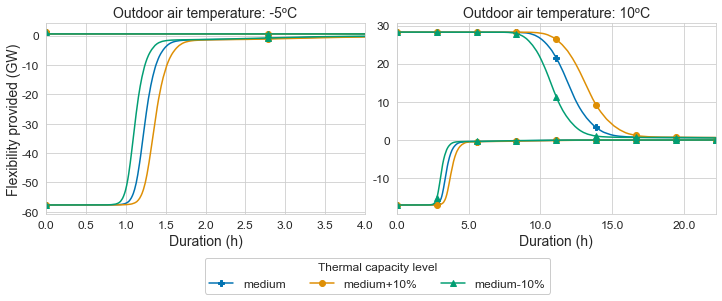

In [ ]:
filter_variables = ["Thermal_capacity_level", "Capacity_factor", "Outside_air_temperature_ºC"]
hue = "Thermal_capacity_level"
ee_measures = "After energy efficiency measures"
f, axs = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]))
list_axs = axs.flatten()
plt.subplots_adjust(wspace=0.1, hspace=0.25)
for ii, OAT in enumerate([-5, 10]):
    ax = list_axs[ii]
    to_plot_df = sensitivity_df.loc[(sensitivity_df["Duration_s"]<max_duration) & (sensitivity_df["Outside_air_temperature_ºC"] == OAT) & (sensitivity_df["Energy_efficiency_measures"]==ee_measures)]
    to_plot_df.set_index("Duration_s", inplace=True)
    ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)
    ax.set_title(f'{Cunit.OAT.label}: {OAT}{Cunit.OAT.unit}', fontsize=14)
    if ii == 0:
        ax.set_xlim(0, 4)
    ax.set_ylabel("")

f.supylabel(f"Flexibility provided ({power_resolution.label})", x=0.08, ha='left', fontsize=14)
legend_dict = visualize.get_legend_parameters(ax, Cunit.THERMALCAP, within_chart=False, horizontal=True)
legend_dict['bbox_to_anchor'] = (0.5, -0.2)
ax.legend(**legend_dict)

In [ ]:
to_plot_df

,Flexibility_kW,Capacity_factor,PDF_inside_air_temperature,Outside_air_temperature_ºC,Scenario,Thermal_capacity_level,Energy_efficiency_measures
Duration_s,,,,,,,
0.0,-1.705562e+07,0,False,10,HP100,medium,After energy efficiency measures
10.0,-1.704885e+07,0,False,10,HP100,medium,After energy efficiency measures
20.0,-1.704885e+07,0,False,10,HP100,medium,After energy efficiency measures
30.0,-1.704885e+07,0,False,10,HP100,medium,After energy efficiency measures
40.0,-1.704885e+07,0,False,10,HP100,medium,After energy efficiency measures
...,...,...,...,...,...,...,...
79950.0,5.517667e+05,1,False,10,HP100,medium-10%,After energy efficiency measures
79960.0,5.517114e+05,1,False,10,HP100,medium-10%,After energy efficiency measures
79970.0,5.515231e+05,1,False,10,HP100,medium-10%,After energy efficiency measures


In [ ]:
conversion_factor = 10/time_resolution.factor # conversion factor to convert flexibility into kWh.
ee_measures = "After energy efficiency measures"

for OAT in [-5, 10]:
    print(f"OAT is {OAT}")
    for capacity_factor in [0,1]:
        print(f"Capacity factor is {capacity_factor}.")
        filt = (sensitivity_df["Duration_s"]<max_duration) & (sensitivity_df["Outside_air_temperature_ºC"] == OAT) & (sensitivity_df["Energy_efficiency_measures"]==ee_measures) & (sensitivity_df["Capacity_factor"]==capacity_factor)
        to_plot_df = sensitivity_df.loc[filt]

        filt = to_plot_df["Thermal_capacity_level"] == "medium"
        medium_energy = (to_plot_df.loc[filt, "Flexibility_kW"] * conversion_factor).sum()/1_000_000

        filt = to_plot_df["Thermal_capacity_level"] == "medium+10%"
        medium_plus10_energy = (to_plot_df.loc[filt, "Flexibility_kW"] * conversion_factor).sum()/1_000_000

        filt = to_plot_df["Thermal_capacity_level"] == "medium-10%"
        medium_minus10_energy = (to_plot_df.loc[filt, "Flexibility_kW"] * conversion_factor).sum()/1_000_000

        print((medium_plus10_energy-medium_energy)/medium_energy*100)
        print((medium_minus10_energy-medium_energy)/medium_energy*100)

OAT is -5
Capacity factor is 0.
9.999217691009438
-9.998624187422381
Capacity factor is 1.
0.0
0.0
OAT is 10
Capacity factor is 0.
9.994469276478467
-9.998063695063724
Capacity factor is 1.
9.598233477659306
-9.626279200305365


{'Energy_efficiency_measures': 'Before energy efficiency measures', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': -5}
{'Energy_efficiency_measures': 'Before energy efficiency measures', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': -5}
{'Energy_efficiency_measures': 'After energy efficiency measures', 'Capacity_factor': 0, 'Outside_air_temperature_ºC': -5}
{'Energy_efficiency_measures': 'After energy efficiency measures', 'Capacity_factor': 1, 'Outside_air_temperature_ºC': -5}
-5
                                                  Flexibility_kW              
                                                             max           min
Energy_efficiency_measures        Capacity_factor                             
After energy efficiency measures  0                -2.611049e+00 -5.770852e+07
                                  1                 1.232776e+06  6.163880e+05
Before energy efficiency measures 0                -9.645935e+00 -8.623706e+07
                             

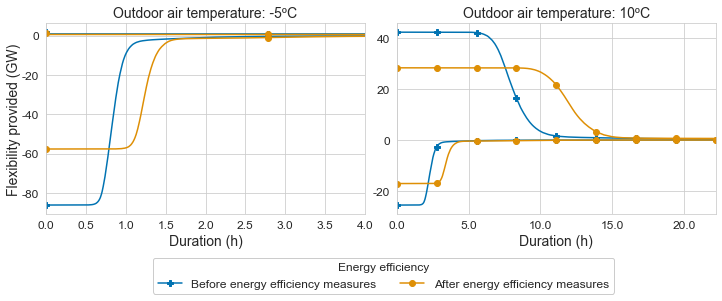

In [ ]:
filter_variables = ["Energy_efficiency_measures", "Capacity_factor", "Outside_air_temperature_ºC"]
hue = "Energy_efficiency_measures"

f, axs = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]))
list_axs = axs.flatten()
plt.subplots_adjust(wspace=0.1, hspace=0.25)
for ii, OAT in enumerate([-5, 10]):
    ax = list_axs[ii]
    to_plot_df = sensitivity_df.loc[(sensitivity_df["Duration_s"]<max_duration) & (sensitivity_df["Outside_air_temperature_ºC"] == OAT) & (sensitivity_df["Thermal_capacity_level"]=="medium")]
    to_plot_df.set_index("Duration_s", inplace=True)
    to_plot_df = to_plot_df.sort_index().sort_values("Energy_efficiency_measures", kind='mergesort', ascending=False)
    ax = visualize.plot_multiple_scenarios_flexibility_results(to_plot_df, filter_variables, hue, time_resolution, power_resolution, ax)
    ax.set_title(f'{Cunit.OAT.label}: {OAT}{Cunit.OAT.unit}', fontsize=14)
    if ii == 0:
        ax.set_xlim(0, 4)
    ax.get_xaxis().set_major_formatter(
        tkr.FuncFormatter(lambda x, p: "{:,.1f}".format(x))
    )
    ax.set_ylabel("")
    print(OAT)
    print(to_plot_df.groupby(["Energy_efficiency_measures", "Capacity_factor"]).agg({"Flexibility_kW":["max", "min"]}))

f.supylabel(f"Flexibility provided ({power_resolution.label})", x=0.08, ha='left', fontsize=14)
legend_dict = visualize.get_legend_parameters(ax, Cunit.EE, within_chart=False, horizontal=True)
legend_dict['bbox_to_anchor'] = (0.7, -0.2)
ax.legend(**legend_dict)

In [ ]:
(-5.798822e+07- (-8.667821e+07))/-8.667821e+07

(4.230652e+07-2.831621e+07)/2.831621e+07

0.49407424228030516

In [ ]:
to_plot_df

,Flexibility_kW,Capacity_factor,PDF_inside_air_temperature,Outside_air_temperature_ºC,Scenario,Thermal_capacity_level,Energy_efficiency_measures
Duration_s,,,,,,,
0.0,-2.548615e+07,0,False,10,HP100,medium,Before energy efficiency measures
0.0,4.224486e+07,1,False,10,HP100,medium,Before energy efficiency measures
10.0,-2.547620e+07,0,False,10,HP100,medium,Before energy efficiency measures
10.0,4.222908e+07,1,False,10,HP100,medium,Before energy efficiency measures
20.0,-2.547620e+07,0,False,10,HP100,medium,Before energy efficiency measures
...,...,...,...,...,...,...,...
79970.0,-5.383685e+02,0,False,10,HP100,medium,After energy efficiency measures
79980.0,6.110437e+05,1,False,10,HP100,medium,After energy efficiency measures
79980.0,-5.383685e+02,0,False,10,HP100,medium,After energy efficiency measures


## Comparison of accuracy of representative dwellings and individual dwellings methods.

In [ ]:
saving_path = os.path.split(os.getcwd())[0]
saving_path = os.path.join(saving_path, "data")

RMSE_kW Ratio
1     60.793814
2     33.862389
4     19.225413
6     13.299382
8     10.131697
10     7.740992
12     6.468402
14     5.398980
16     4.608527
18     3.905057
20     3.478058
Name: median, dtype: float64
MAPE_% Ratio
1     0.732699
2     0.558357
4     0.367278
6     0.275610
8     0.223911
10    0.188602
12    0.166224
14    0.154805
16    0.149001
18    0.136977
20    0.131936
Name: median, dtype: float64
MAE_kW Ratio
1     35.882032
2     19.814465
4     10.867942
6      7.584868
8      5.616621
10     4.410607
12     3.735366
14     3.042270
16     2.634147
18     2.175062
20     1.968732
Name: median, dtype: float64


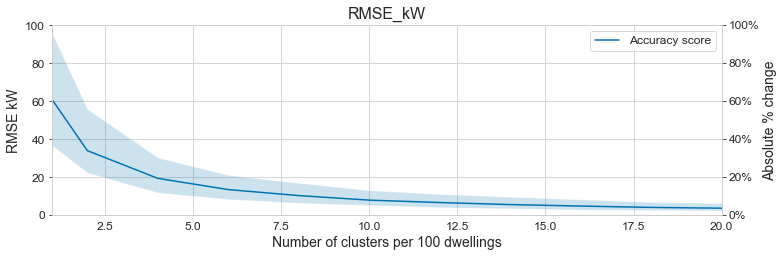

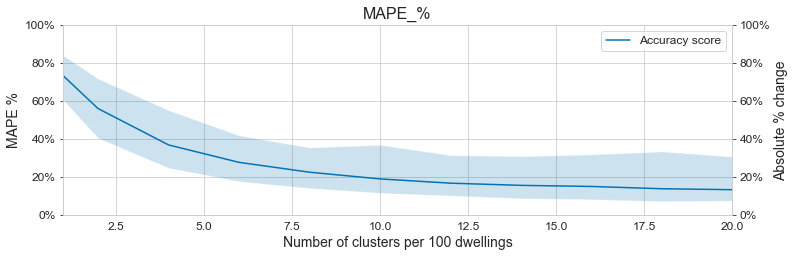

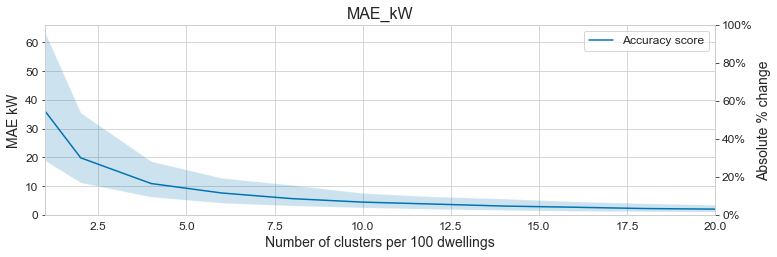

In [ ]:
nb_lsoas = 300
capacity_factor = 0
filename = f'final_scores_{nb_lsoas}_cf_{capacity_factor}_lsoas.csv'
final_scores_df = pd.read_csv(os.path.join(saving_path, filename), index_col=0)
frames = visualize.plot_accuracy_plots(final_scores_df)

RMSE_kW Ratio
1     31.818895
2     18.339414
4     10.424462
6      7.099628
8      5.438916
10     4.340501
12     3.515901
14     2.931059
16     2.484341
18     2.178800
20     1.875152
Name: median, dtype: float64
MAPE_% Ratio
1     0.488733
2     0.374393
4     0.225238
6     0.163490
8     0.133999
10    0.114723
12    0.102279
14    0.097591
16    0.088846
18    0.087036
20    0.083822
Name: median, dtype: float64
MAE_kW Ratio
1     16.800771
2      9.885644
4      5.469861
6      3.848524
8      2.820836
10     2.189209
12     1.791843
14     1.468872
16     1.243742
18     1.103829
20     0.995686
Name: median, dtype: float64


[[<Figure size 864x252 with 2 Axes>,
  <AxesSubplot:title={'center':'RMSE_kW'}, xlabel='Number of clusters per 100 dwellings', ylabel='RMSE kW'>],
 [<Figure size 864x252 with 2 Axes>,
  <AxesSubplot:title={'center':'MAPE_%'}, xlabel='Number of clusters per 100 dwellings', ylabel='MAPE %'>],
 [<Figure size 864x252 with 2 Axes>,
  <AxesSubplot:title={'center':'MAE_kW'}, xlabel='Number of clusters per 100 dwellings', ylabel='MAE kW'>]]

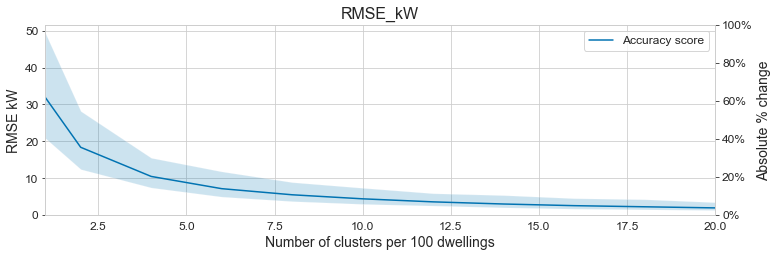

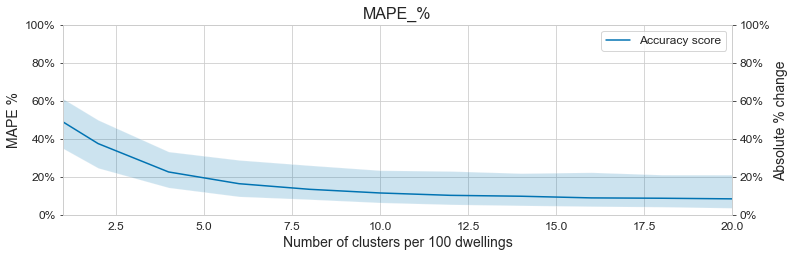

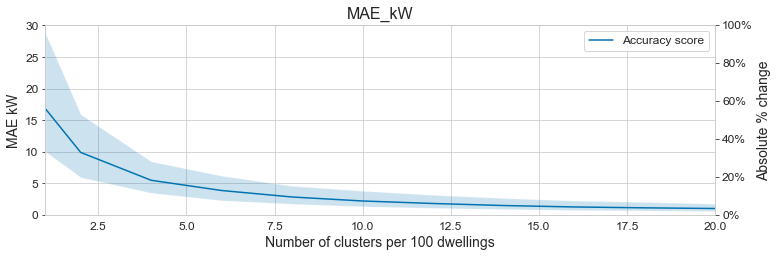

In [ ]:
nb_lsoas = 300
capacity_factor = 1
filename = f'final_scores_{nb_lsoas}_cf_{capacity_factor}_lsoas.csv'
final_scores_df = pd.read_csv(os.path.join(saving_path, filename), index_col=0)
visualize.plot_accuracy_plots(final_scores_df)

In [ ]:
## Comparison of computational ressources used between individual dwellings model and representative dwellings model

In [ ]:
nb_lsoas = 300
capacity_factor = 0
filename = f'final_scores_{nb_lsoas}_cf_{capacity_factor}_lsoas.csv'
final_scores_df = pd.read_csv(os.path.join(saving_path, filename), index_col=0)

In [ ]:
from pyinstrument import Profiler
profiler = Profiler()

capacity_factor = 0
dataf = lsoa_data.copy()
number_of_loops = 5
ratio = 15
number_cols = [c for c in dataf.columns if "Number of" in c and "2018" in c]
nb_dwellings_per_cluster = 100

(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_inside_air_temperature_func(capacity_factor)

list_lsoas = lsoa_data.sample(1).index
nb_dwellings = dataf.loc[dataf.index.isin(list_lsoas), number_cols].sum().sum()
nb_cluster = int(round(nb_dwellings / nb_dwellings_per_cluster * ratio, 0))

## Start profiler
profiler.start()

flex_obj = (
    dm.Dwellings(list_lsoas, T_limit, capacity_factor, demand_increase)
    .create_dwellings(dataf)
    .add_variables(temperature_func)
    .cluster_dwellings(nb_cluster)
    .create_representative_dwellings_df(Keyword.SUM)
    .get_duration_service(Method.REPRESENTATIVE))

## Stop profiler
profiler.stop()
profiler.print()

AttributeError: module 'flexibility.dwelling_functions' has no attribute 'get_inside_air_temperature_func'

In [ ]:
profiler = Profiler()
## Start profiler
profiler.start()

flex_obj = (
    dm.Dwellings(list_lsoas, T_limit, capacity_factor, demand_increase)
    .create_dwellings(dataf)
    .add_variables(temperature_func)
    .get_duration_service(Method.INDIVIDUAL))

## Stop profiler
profiler.stop()
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:37:08  Samples:  7090
 /_//_/// /_\ / //_// / //_'/ //     Duration: 7.262     CPU time: 7.250
/   _/                      v4.1.1

Program: c:\Users\sceac10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"9612de9b-4373-4c9a-84a6-681577530b69" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\sceac10\AppData\Roaming\jupyter\runtime\kernel-3952SB7k91QuUilw.json

7.262 run_code  IPython\core\interactiveshell.py:3396
└─ 7.262 <module>  <ipython-input-112-7f9afecacd61>:6
   ├─ 4.985 get_duration_service  flexibility\dwellings_model.py:371
   │  └─ 4.911 apply  pandas\core\frame.py:7625
   │        [90 frames hidden]  pandas, <built-in>, <__array_function...
   │           4.883 apply_series_generator  pandas\core\apply.py:281
   │           ├─ 4.304 <lambda>  flexibility\dwellings_model.py:381
   │  

In [ ]:
import timeit

def get_number_dwellings(dataf, number_of_lsoas):

    lsoas_dict = {5: [20734, 17714, 13723, 22186, 24456],
    10:[31516, 19151, 31201, 21390, 23709, 30094, 5825, 34613, 21631, 21955],
    15:[13211,  1592,  5215, 19359, 26587,  9668, 13399, 26453, 12115, 30339, 26848, 29084, 30142,  8560, 17917],
    20:[21813, 26038, 32640,  7229, 15760,  4032, 22614,  4716, 17966, 22150,  6589, 10266, 11389, 14955, 19057,  9608, 11602, 30108,13171, 10090],
    50:[34658,  4556, 18075, 34327, 10624, 29776, 33211, 15144, 27984, 29174, 18244,  6398, 30061,  3250, 17697,  2604,  4235,  9245, 1255, 17891,
    6514, 11927, 33443, 30305, 24231, 33215,  9063, 13088, 11400, 26044, 18278, 16345, 11127, 28479, 11760,   835, 28991,
    3094, 11553, 17278, 27569,  6501, 30256,  5392,  1900,12496, 29768, 27690,  1998,  5480],
    100:[ 9966, 30495, 24315,  4950, 17382, 32916, 12826,  8356, 17542,
             6371, 16203, 28774, 29096, 27754, 12224, 17599,  5229,  3709,
            11827, 20886,  1788, 18337,   678, 32725, 20358,  9499, 17399,
             5416, 16123,  8431, 31074, 30279, 13907, 33188, 25392,  1635,
             5287,   395,  7309, 29526,  7665, 26021, 29311, 12454, 15493,
            29317, 32301, 21589, 27516, 32024, 18326, 32245,  7584, 19804,
            28029, 18916, 14576, 16741, 13865, 30865, 32805, 29746,  6309,
            13410, 23397, 32329,  2741,  1440,  1624, 25780,  2917, 12177,
            28388,  8198, 26705, 29104,  4260,   544,  4517,  8793, 16876,
              920,  1806,  3369, 31783, 12515, 11502, 28789,   663, 21272,
            26958,  7225, 10791, 15657, 32980, 15859,  1963, 16686, 27256,
             8915]}

    list_lsoas = lsoas_dict[number_of_lsoas]
    number_cols = [c for c in dataf.columns if "Number of" in c and "2018" in c]            
    return dataf.loc[dataf.index.isin(list_lsoas), number_cols].sum().sum()

def get_setup(new_nb):
    parameters = f'nb = {new_nb}'
    text =  '''
import pandas as pd
import flexibility.dwellings_model as dm
import flexibility.dwelling_functions as dwelling_functions
from flexibility.enums import Method, Keyword
saving_path = r"D:\\OneDrive - Cardiff University\\04 - Projects\\03 - PhD\\03 - Analysis\\03 - LSOAs\\00 - Data\\Domestic_EPC_results\\EPC_thermal_capacity"
dataf = pd.read_csv(saving_path+'Thermal_characteristics_LSOA_EandW.csv', index_col=0) 
dataf.reset_index(inplace=True)

lsoas_dict = {5: [20734, 17714, 13723, 22186, 24456],
10:[31516, 19151, 31201, 21390, 23709, 30094, 5825, 34613, 21631, 21955],
15:[13211,  1592,  5215, 19359, 26587,  9668, 13399, 26453, 12115, 30339, 26848, 29084, 30142,  8560, 17917],
20:[21813, 26038, 32640,  7229, 15760,  4032, 22614,  4716, 17966, 22150,  6589, 10266, 11389, 14955, 19057,  9608, 11602, 30108,13171, 10090],
50:[34658,  4556, 18075, 34327, 10624, 29776, 33211, 15144, 27984, 29174, 18244,  6398, 30061,  3250, 17697,  2604,  4235,  9245, 1255, 17891,
6514, 11927, 33443, 30305, 24231, 33215,  9063, 13088, 11400, 26044, 18278, 16345, 11127, 28479, 11760,   835, 28991,
3094, 11553, 17278, 27569,  6501, 30256,  5392,  1900,12496, 29768, 27690,  1998,  5480],
100:[ 9966, 30495, 24315,  4950, 17382, 32916, 12826,  8356, 17542,
            6371, 16203, 28774, 29096, 27754, 12224, 17599,  5229,  3709,
        11827, 20886,  1788, 18337,   678, 32725, 20358,  9499, 17399,
            5416, 16123,  8431, 31074, 30279, 13907, 33188, 25392,  1635,
            5287,   395,  7309, 29526,  7665, 26021, 29311, 12454, 15493,
        29317, 32301, 21589, 27516, 32024, 18326, 32245,  7584, 19804,
        28029, 18916, 14576, 16741, 13865, 30865, 32805, 29746,  6309,
        13410, 23397, 32329,  2741,  1440,  1624, 25780,  2917, 12177,
        28388,  8198, 26705, 29104,  4260,   544,  4517,  8793, 16876,
            920,  1806,  3369, 31783, 12515, 11502, 28789,   663, 21272,
        26958,  7225, 10791, 15657, 32980, 15859,  1963, 16686, 27256,
            8915]}

list_lsoas = lsoas_dict[nb]
nb_dwellings_per_cluster = 100
capacity_factor = 0
ratio = 15
(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_inside_air_temperature_func(capacity_factor)

temp_flex_obj = (dm.Dwellings(list_lsoas, T_limit, capacity_factor, demand_increase)
                .create_dwellings(dataf)
                .add_variables(temperature_func))

number_cols = [c for c in dataf.columns if "Number of" in c and "2018" in c]            
nb_dwellings = dataf.loc[dataf.index.isin(list_lsoas), number_cols].sum().sum()
nb_cluster = int(round(nb_dwellings / nb_dwellings_per_cluster * ratio, 0))
'''
    return parameters+text

def get_stmt_individual():
    text = '''
temp_flex_obj.get_duration_service(Method.INDIVIDUAL)
    '''
    return text

def get_stmt_representative():
    text = '''
(temp_flex_obj
.cluster_dwellings(nb_cluster)
.create_representative_dwellings_df(Keyword.SUM)
.get_duration_service(Method.REPRESENTATIVE))
    '''
    return text

nb_repeat = 4
concat_individual_results = []
list_number_of_lsoas = [5]

for temp_nb in list_number_of_lsoas:
    print(f"Number of lsoas is {temp_nb}")
    setup = get_setup(temp_nb)
    stmt =  get_stmt_individual()
    temp_results = timeit.repeat(stmt=stmt, setup=setup, repeat = nb_repeat, number = 5)
    nb_dwellings = get_number_dwellings(lsoa_data, temp_nb)
    concat_individual_results.append(temp_results+[nb_dwellings])

Number of lsoas is 5
Number of lsoas is 50
Number of lsoas is 100


In [ ]:
concat_representative_results = []

for temp_nb in list_number_of_lsoas:
    print(f"Number of lsoas is {temp_nb}")
    setup = get_setup(temp_nb)
    stmt =  get_stmt_representative()
    temp_results = timeit.repeat(stmt=stmt, setup=setup, repeat = nb_repeat, number = 5)
    nb_dwellings = get_number_dwellings(lsoa_data, temp_nb)
    concat_representative_results.append(temp_results+[nb_dwellings])

Number of lsoas is 5
Number of lsoas is 50


KeyboardInterrupt: 

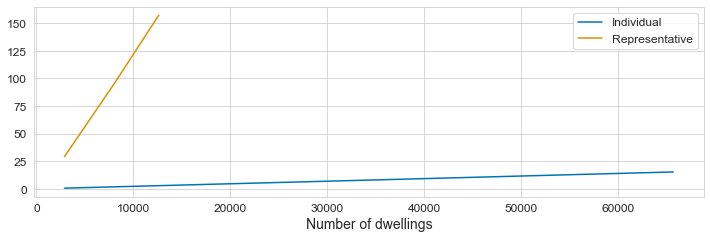

In [ ]:
f, ax = plt.subplots(figsize=figsize)

results_df = pd.DataFrame(concat_individual_results, columns =[f"Iteration {x+1}" for x in range(nb_repeat)]+["Number of dwellings"])
results_df.set_index("Number of dwellings", drop=True, inplace=True)
results_df.mean(axis=1).plot(ax=ax, label='Individual')

results_df = pd.DataFrame(concat_representative_results, columns =[f"Iteration {x+1}" for x in range(nb_repeat)]+["Number of dwellings"])
results_df.set_index("Number of dwellings", drop=True, inplace=True)

results_df.mean(axis=1).plot(ax=ax, label='Representative')
ax.legend()

## Impact of change of R and C parameters on the duration of service

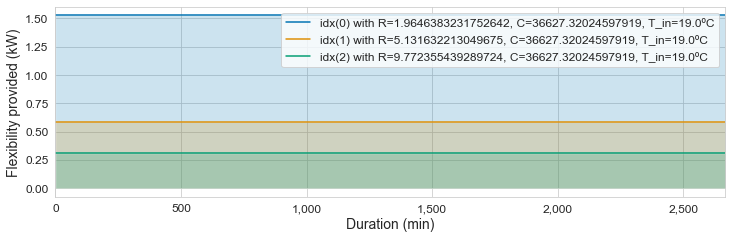

In [ ]:
categories = ['detached gas boiler',
              'semi-detached resistance heating',
              'flat resistance heating'
             ]

index_lsoa=[1500]
capacity_factor = 1
T_limit = 28
C_constant_dwellings = dm.Dwellings(index_lsoa, T_limit, capacity_factor, True)
C_constant_dwellings.categories = categories
C_constant_dwellings.initial_indoor_temperature = 19
C_constant_dwellings.thermal_capacity_level = 'high'
C_constant_dwellings = C_constant_dwellings.create_dwellings(lsoa_data)
C_constant_df = C_constant_dwellings.dwellings_df
C_constant_df = C_constant_df.drop_duplicates(subset=['C_kJ/K', 'R_K/kW']).copy()
C_constant_df['C_kJ/K'] = C_constant_df['C_kJ/K'].mean()
C_constant_dwellings.dwellings_df = C_constant_df

C_constant_dwellings = (C_constant_dwellings
                        .add_variables(None)
                        .get_duration_service(dm.Method.INDIVIDUAL))


C_constant_df = C_constant_dwellings.temp_df
f, ax = visualize.plot_duration_individual_dwellings(C_constant_df,160000, 'min', 'kW')
ax.legend()

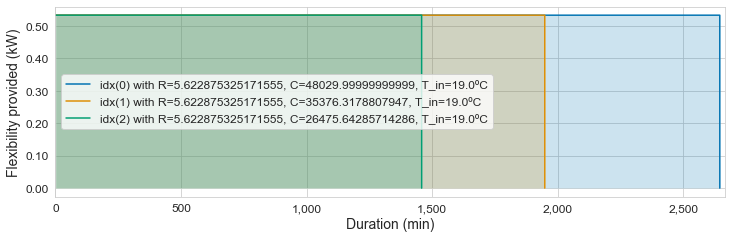

In [ ]:
categories = ['detached gas boiler',
              'semi-detached resistance heating',
              'flat resistance heating'
             ]

index_lsoa=[1500]
capacity_factor = 1
T_limit = 23
R_constant_dwellings = dm.Dwellings(index_lsoa, T_limit, capacity_factor)
R_constant_dwellings.categories = categories
R_constant_dwellings.initial_indoor_temperature = 19
R_constant_dwellings.thermal_capacity_level = 'high'
R_constant_dwellings = R_constant_dwellings.create_dwellings(lsoa_data)
R_constant_df = R_constant_dwellings.dwellings_df
R_constant_df = R_constant_df.drop_duplicates(subset=['C_kJ/K', 'R_K/kW']).copy()
R_constant_df['R_K/kW'] = R_constant_df['R_K/kW'].mean()

R_constant_dwellings.dwellings_df = R_constant_df

R_constant_dwellings = (R_constant_dwellings
                        .add_variables(None)
                        .get_duration_service(dm.Method.INDIVIDUAL))

R_constant_df = R_constant_dwellings.temp_df
f, ax = visualize.plot_duration_individual_dwellings(R_constant_df, 160000, 'min', 'kW')
ax.legend()

## Impact of inside air temperature on results

In [ ]:
# for a single dwelling

categories = ['detached gas boiler',
             ]

index_lsoa=[1500]
capacity_factor = 1

(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_inside_air_temperature_func(
    capacity_factor
)

RC_constant_dwellings = dm.Dwellings(index_lsoa, T_limit, capacity_factor)
RC_constant_dwellings.categories = categories
RC_constant_dwellings.initial_indoor_temperature = 19
RC_constant_dwellings.thermal_capacity_level = 'high'
RC_constant_dwellings = RC_constant_dwellings.create_dwellings(lsoa_data)
RC_constant_df = RC_constant_dwellings.dwellings_df
RC_constant_df = RC_constant_df.drop_duplicates(subset=['C_kJ/K', 'R_K/kW']).copy()

# Create additional identical dwellings
copy_org_df = RC_constant_df.copy()
for _ in range(500):
    RC_constant_df = RC_constant_df.append(copy_org_df)
nb_dwellings = len(RC_constant_df)
RC_constant_df.reset_index(inplace=True, drop=True)
RC_constant_dwellings.dwellings_df = RC_constant_df

RC_constant_dwellings = (RC_constant_dwellings
                        .add_variables(None))

RC_constant_dwellings.dwellings_df['Initial_indoor_temperature_ºC'] = np.linspace(14, 24, nb_dwellings)

RC_constant_dwellings.dwellings_df = RC_constant_dwellings.calculate_initial_variables(RC_constant_dwellings.dwellings_df)
RC_constant_dwellings = RC_constant_dwellings.get_duration_service(dm.Method.INDIVIDUAL)
RC_constant_df = RC_constant_dwellings.temp_df.copy()
RC_constant_df.index.name = 'Index'
RC_constant_df.reset_index(inplace=True)
# f, ax = visualize.plot_duration_individual_dwellings(RC_constant_df, 160000, 'min', 'kW')
# ax.legend()


0.3371694242213513
0.0


Text(0.5, 0, 'Duration_s')

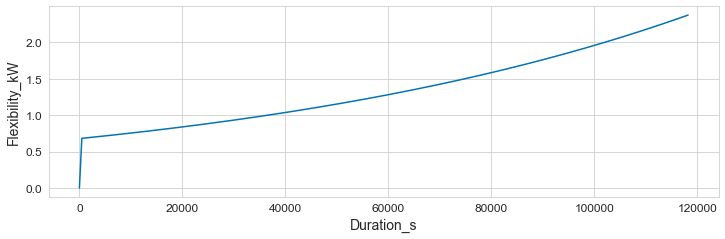

In [ ]:
f, ax = plt.subplots(figsize=figsize)
dataf = RC_constant_df[['Flexibility_provided_kW', 'Duration_s']].copy()

if nb_dwellings>len(dataf):
    #Dwellings which did not provided any flexibility were removed from the dataset
    dataf = dataf.append({'Flexibility_provided_kW':0, 'Duration_s':0}, ignore_index=True)

dataf.sort_values(['Flexibility_provided_kW', 'Duration_s'], inplace=True)

y_arr = dataf['Flexibility_provided_kW'].values
x_arr = dataf['Duration_s'].values

ax.plot(x_arr, y_arr)
ax.set_ylabel('Flexibility_kW')
ax.set_xlabel('Duration_s')
# 24-10

In [ ]:
import copy
# for a group of identical dwellings
capacity_factor = 1
demand_increase = True # default assumption
index_lsoa= [1500]
categories = ['detached gas boiler',
             ]

(
    temperature_func,
    T_limit,
    demand_increase,
) = dwelling_functions.get_inside_air_temperature_func(
    capacity_factor,
)

# Monte Carlo simulation

# Create a Dwellings object of identical dwellings
RC_constant_dwellings = dm.Dwellings(index_lsoa, T_limit, capacity_factor)
RC_constant_dwellings.categories = categories
RC_constant_dwellings.initial_indoor_temperature = 19
RC_constant_dwellings.thermal_capacity_level = 'medium'
RC_constant_dwellings = RC_constant_dwellings.create_dwellings(lsoa_data)
RC_constant_df = RC_constant_dwellings.dwellings_df
RC_constant_df = RC_constant_df.drop_duplicates(subset=['C_kJ/K', 'R_K/kW']).copy()

# Create additional identical dwellings
copy_org_df = RC_constant_df.copy()
for _ in range(500):
    RC_constant_df = RC_constant_df.append(copy_org_df)
nb_dwellings = len(RC_constant_df)
RC_constant_df.reset_index(inplace=True, drop=True)
RC_constant_dwellings.dwellings_df = RC_constant_df

RC_constant_dwellings = (RC_constant_dwellings
                        .add_variables(None))
                        
frames = []
for _ in range(100):
    temp_dwellings_obj = copy.deepcopy(RC_constant_dwellings)
    temp_dwellings_obj.dwellings_df['Initial_indoor_temperature_ºC'] = [temperature_func(x) for x in range(nb_dwellings)]

    temp_dwellings_obj.dwellings_df = temp_dwellings_obj.calculate_initial_variables(temp_dwellings_obj.dwellings_df)
    temp_dwellings_obj = (temp_dwellings_obj
                            .get_duration_service(dm.Method.INDIVIDUAL)
                            .concat_results())

    frames.append(temp_dwellings_obj.concat_results_df['Flexibility_provided_(Individual_dwellings)_kW'].to_frame().copy())

0.3371694242213513
0.0


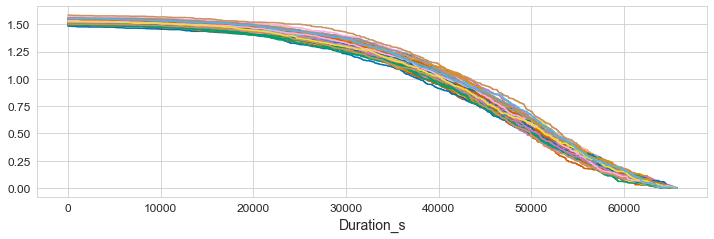

In [ ]:
final_df = pd.concat(frames, axis=1).fillna(0)/nb_dwellings
f, ax = plt.subplots(figsize=figsize)
final_df.plot(ax=ax)
ax.legend().remove()

# For an aggregation of LSOAs and multiple scenarios

In [ ]:
def get_representative_dwellings(
    dataf:pd.DataFrame,
    list_lsoas: List[int],
    ratio:int = 10,
    nb_dwellings_per_cluster: int = 100,
) -> pd.DataFrame:

    capacity_factor = 0 # only used as input to get the temperature func but does not impact the process
    (
        temperature_func,
        T_limit,
        demand_increase,
    ) = dwelling_functions.get_inside_air_temperature_func(capacity_factor)

    nb_dwellings_cols = [c for c in dataf.columns if "Number of" in c and "2018" in c]
    nb_dwellings = dataf.loc[list_lsoas, nb_dwellings_cols].sum().sum()
    nb_cluster = int(round(nb_dwellings / nb_dwellings_per_cluster * ratio, 0))

    flex_obj = (
        dm.Dwellings(list_lsoas, T_limit, capacity_factor, demand_increase)
        .create_dwellings(dataf)
        .add_variables(temperature_func)
        .cluster_dwellings(nb_cluster)
        .create_representative_dwellings_df(Keyword.SUM)
    )

    return flex_obj.representative_dwellings_df

'd:\\OneDrive - Cardiff University\\04 - Projects\\20 - UKERC\\03 - Code\\flexibilitydwellings\\data\\representative_dwellings'

In [ ]:
# capacity_factor = 0
# nb_lsoas = 100 #number of lsoas inputted to the model each time
# results_frames = []
# nb_slices = 10
# filename = ""
# interval = int(len(dataf) / nb_slices)
# ratio = 10

# for sl in range(0, nb_slices):
#     start_idx = sl * interval
#     if sl + 1 == nb_slices:
#         end_idx = len(dataf)
#     else:
#         end_idx = (sl + 1) * interval
#     print(sl, start_idx, end_idx)
#     temp_index = np.array(dataf.iloc[start_idx:end_idx].index)

#     for index_lsoas in np.array_split(temp_index, len(temp_index) / nb_lsoas):
#         representatives_df = get_representative_dwellings(lsoa_data, index_lsoas, ratio=ratio)
#         results_frames.append(representatives_df)

#     if filename == "":
#         final_filename = f"representative_dwellings_slice_{sl}_ratio_{ratio}.csv"
#     else:
#         final_filename = filename
#     pd.concat(results_frames, axis=1).to_csv(os.path.join(saving_path, final_filename))

0 0 3475


In [ ]:
list_number_dwellings_per_cluster = np.concatenate(
    [[1], np.arange(2, 22, 2)]
) 
list_number_dwellings_per_cluster


array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

## Results based on service durations

In [ ]:

# temp_frames = flexiblity.run_model_multiple_lsoas(methods, nb_lsoas=100, filename="test.csv")

688.0

,Flexibility_provided_(Individual_dwellings)_kW
Duration_s,
0.0,-888.330537
10.0,-887.808612
20.0,-887.808612
30.0,-887.808612
40.0,-887.808612
...,...
44220.0,-0.301680
44230.0,-0.301680
44240.0,-0.301680


In [ ]:
# service_durations = [0, 1*60, 30*60,2*60*60, 4*60*60] # 30min, and 4 hours
# init_indoor_temperatures = [23,22, 21, 20, 19, 18, 17,16 , 15]
# final_indoor_temperatures = [23,22, 21, 20, 19, 18, 17,16 , 15]
# outdoor_temperatures = [0, 5, 10]

# combined_list = [service_durations, init_indoor_temperatures, final_indoor_temperatures, outdoor_temperatures ]
# list(itertools.product(*combined_list))

In [ ]:
# results_frame = []

# for index_lsoa in lsoa_data.loc[:, 'LSOA11CD'].sample(10).index:
#     lsoa_name = lsoa_data.loc[index_lsoa, 'LSOA11CD']
#     total_R = 1/lsoa_data.loc[index_lsoa, 'Total thermal losses kW/K']  
#     total_C = (lsoa_data.loc[index_lsoa, 'Total high thermal capacity GJ/K']*1000000) #K/kJ
#     design_temperature = lsoa_data.loc[index_lsoa, 'Design_temperature_degreeC']  
#     print(f'In LSOA: {lsoa_name}, the aggregated dwellings have a total R of {total_R} kW/K, C of {total_C} K/kJ')
#     print(f'The design temperature in this LSOA is {design_temperature} C')
    
#     max_P_out = 1/total_R * (21-design_temperature) # kW
#     COP = 3
#     scenario = '100% ASHPs' 

#     for duration, init_T_in, final_T_in, init_T_out in itertools.product(*combined_list):
#     #     print(f'duration {duration}, init indoor temperature {init_T_in}, final indoor temperature {final_T_in}, outdoor temperature {init_T_out}')

#         delta_T = (init_T_in-init_T_out)
#         if delta_T > 0:
#             init_P_out = 1/total_R*delta_T #W output from heat pump to maintain init_T_in temperature
#         else:
#             init_P_out = 0

#     #     print(f'The initial heat output is {init_P_out} kW. It maintains the indoor temperature at {init_T_in} C.')

#         increase_demand = False
#         if final_T_in>init_T_in: 
#             #Increase in demand is requested
#             increase_demand = True

#         required_P_output = tm.get_heating_output(init_T_in, init_T_out, total_R, total_C, final_T_in, duration)
#     #     print(f'An additional heat output of {required_P_output} kW should be provided to reach the final temperature of {final_T_in} in {duration/60} min')

#         if increase_demand:
#             if required_P_output > max_P_out:
#                 required_P_output = max_P_out
#             power_provided = (required_P_output-init_P_out)/COP
#             if power_provided < 0:
#                 power_provided = 0
#     #         print(f'A demand increase of {power_provided} kW can be provided for {duration/60} min')
#         else:
#             if required_P_output < 0:
#                 required_P_output = 0
#             power_provided = (required_P_output-init_P_out)/COP
#             if power_provided < -max_P_out:
#                 power_provided = -max_P_out
#     #         print(f'A demand reduction of {power_provided} kW can be provided for {duration/60} min')     

#         temp_results = [lsoa_name, duration, init_T_in, final_T_in, init_T_out, power_provided.round(0), COP, scenario]
#         results_frame.append(temp_results)

In [ ]:
# columns = ['LSOA_name',
#            'Duration_sec', 
#            'Initial_indoor_temperature_ºC', 
#            'Final_indoor_temperature_ºC',
#            'Outdoor_temperature_ºC',
#            'Flexibility_provided_kW',
#           'COP_ASHPs',
#           'Scenario']
# dataf = pd.DataFrame(results_frame, columns = columns)
# dataf.index.name = 'index'
# dataf['Difference_indoor_temperature_ºC'] = dataf['Initial_indoor_temperature_ºC'] - dataf['Final_indoor_temperature_ºC']

# dataf['Demand_reduction_kW'] = -dataf.loc[dataf['Flexibility_provided_kW'] < 0, 'Flexibility_provided_kW']
# dataf['Demand_reduction_kW'].fillna(0, inplace=True)
# dataf['Demand_increase_kW'] = dataf.loc[dataf['Flexibility_provided_kW'] >0, 'Flexibility_provided_kW']
# dataf['Demand_increase_kW'].fillna(0, inplace=True)
# dataf.to_csv(ukerc_path_data+os.path.sep+'01 - results'+os.path.sep+"flexibility.csv")

In [ ]:
# initial_indoor_temperature = 16
# upper_target_indoor_temperature = initial_indoor_temperature + 1
# lower_target_indoor_temperature = initial_indoor_temperature - 1
# outdoor_temperature = 0
# column = 'Final_indoor_temperature_ºC'
# if upper_target_indoor_temperature not in dataf['Final_indoor_temperature_ºC'].unique():
#     print(f'{upper_target_indoor_temperature} not in the column named {column}')
    
# column = 'Final_indoor_temperature_ºC'
# if lower_target_indoor_temperature not in dataf['Final_indoor_temperature_ºC'].unique():
#     print(f'{lower_target_indoor_temperature} not in the column named {column}')
    
# filters = ((dataf['Initial_indoor_temperature_ºC'] == initial_indoor_temperature)
#        & (dataf['Outdoor_temperature_ºC'] == outdoor_temperature)
#        & ((dataf['Final_indoor_temperature_ºC'] <= upper_target_indoor_temperature)
#        | (dataf['Final_indoor_temperature_ºC'] >= lower_target_indoor_temperature))
#       )
# to_plot_df = dataf.loc[filters].copy()
# len(to_plot_df)



# to_plot_df['Flexibility_provided_(absolute)_kW'] = to_plot_df['Flexibility_provided_kW'].abs()
# to_plot_df

In [ ]:
# to_plot_df = (to_plot_df
#               .groupby(['Duration_sec', 'Difference_indoor_temperature_ºC'])
#               .agg({'Flexibility_provided_(absolute)_kW':'sum'}))

# to_plot_df.reset_index(inplace=True)
# to_plot_df.loc[to_plot_df['Difference_indoor_temperature_ºC']>=0, 'Flexibility_service'] = 'Increase_demand'
# to_plot_df.loc[to_plot_df['Difference_indoor_temperature_ºC']<0, 'Flexibility_service'] = 'Decrease_demand'
# to_plot_df

## results based on power output

In [ ]:
# def estimate_duration_services(dataf, combined_list, scenario, list_lsoas = []):
#     results_frame = []
#     if len(list_lsoas)==0:
#         list_lsoas = dataf.loc[:, 'LSOA11CD'].index

#     for index_lsoa in list_lsoas:
#         lsoa_name = dataf.loc[index_lsoa, 'LSOA11CD']
#         total_R = 1/dataf.loc[index_lsoa, 'Total thermal losses kW/K']  
#         total_C = (dataf.loc[index_lsoa, 'Total high thermal capacity GJ/K']*1000000) #K/kJ
#         design_temperature = dataf.loc[index_lsoa, 'Design_temperature_degreeC']  
#     #     print(f'In LSOA: {lsoa_name}, the aggregated dwellings have a total R of {total_R} kW/K, C of {total_C} K/kJ')
#     #     print(f'The design temperature in this LSOA is {design_temperature} C')

#         max_P_out = 1/total_R * (21-design_temperature) # kW
#         COP = 3
#         scenario = '100% ASHPs' 

#         for P_percentage, init_T_in, T_limit, init_T_out in itertools.product(*combined_list):
#         #     print(f'duration {duration}, init indoor temperature {init_T_in}, final indoor temperature {final_T_in}, outdoor temperature {init_T_out}')

#             increase_demand = False
#             if P_percentage > 0: 
#                 increase_demand = True

#             delta_T = (init_T_in-init_T_out)
#             if delta_T > 0:
#                 init_P_out = 1/total_R*delta_T #W output from heat pump to maintain init_T_in temperature
#             else:
#                 init_P_out = 0

#             temp_P_out = P_percentage*max_P_out

#             if temp_P_out > max_P_out:
#                 duration = np.nan
#             elif temp_P_out < 0:
#                 duration = np.nan
#             else:
#                 duration = tm.get_duration_service(init_T_in, init_T_out, temp_P_out, total_R, total_C, T_limit)

#             if init_P_out > temp_P_out:   
#                 flexibility_provided = -(init_P_out-temp_P_out)/COP
#             else:
#                 flexibility_provided = (init_P_out-temp_P_out)/COP

#             initial_power = init_P_out/COP
#             provided_power = temp_P_out/COP
#             if duration > 0 or duration == -1:
#                 # for plotting purposes to add the origin points
#                 temp_results = [lsoa_name, 0, init_T_in, T_limit, init_T_out, P_percentage, flexibility_provided/COP, initial_power, provided_power, COP, scenario]
#                 results_frame.append(temp_results)

#             temp_results = [lsoa_name, duration, init_T_in, T_limit, init_T_out, P_percentage, flexibility_provided/COP, initial_power, provided_power, COP, scenario]
#             results_frame.append(temp_results)
            
#     return results_frame

In [ ]:
# results_frame = []
# print(lsoa_data.loc[:, 'LSOA11CD'].sample(20).index)
# list_lsoas = [11148, 22056, 14876, 24629, 34624, 31769, 22881, 15124,  8029,
#             18059, 18319, 31743, 10755,  6305,  2304, 34731, 19117, 12846,
#             18032,  9573]
# for index_lsoa in lsoa_data.loc[:, 'LSOA11CD'].index:
#     lsoa_name = lsoa_data.loc[index_lsoa, 'LSOA11CD']
#     total_R = 1/lsoa_data.loc[index_lsoa, 'Total thermal losses kW/K']  
#     total_C = (lsoa_data.loc[index_lsoa, 'Total high thermal capacity GJ/K']*1000000) #K/kJ
#     design_temperature = lsoa_data.loc[index_lsoa, 'Design_temperature_degreeC']  
# #     print(f'In LSOA: {lsoa_name}, the aggregated dwellings have a total R of {total_R} kW/K, C of {total_C} K/kJ')
# #     print(f'The design temperature in this LSOA is {design_temperature} C')
    
#     max_P_out = 1/total_R * (21-design_temperature) # kW
#     COP = 3
#     scenario = '100% ASHPs' 

#     for P_percentage, init_T_in, T_limit, init_T_out in itertools.product(*combined_list):
#     #     print(f'duration {duration}, init indoor temperature {init_T_in}, final indoor temperature {final_T_in}, outdoor temperature {init_T_out}')

#         increase_demand = False
#         if P_percentage > 0: 
#             increase_demand = True
    
#         delta_T = (init_T_in-init_T_out)
#         if delta_T > 0:
#             init_P_out = 1/total_R*delta_T #W output from heat pump to maintain init_T_in temperature
#         else:
#             init_P_out = 0

#         temp_P_out = P_percentage*max_P_out
        
#         if temp_P_out > max_P_out:
#             duration = np.nan
#         elif temp_P_out < 0:
#             duration = np.nan
#         else:
#             duration = tm.get_duration_service(init_T_in, init_T_out, temp_P_out, total_R, total_C, T_limit)

#         if init_P_out > temp_P_out:   
#             flexibility_provided = -(init_P_out-temp_P_out)/COP
#         else:
#             flexibility_provided = (init_P_out-temp_P_out)/COP
            
#         initial_power = init_P_out/COP
#         provided_power = temp_P_out/COP
#         if duration > 0 or duration == -1:
#             # for plotting purposes to add the origin points
#             temp_results = [lsoa_name, 0, init_T_in, T_limit, init_T_out, P_percentage, flexibility_provided/COP, initial_power, provided_power, COP, scenario]
#             results_frame.append(temp_results)
            
#         temp_results = [lsoa_name, duration, init_T_in, T_limit, init_T_out, P_percentage, flexibility_provided/COP, initial_power, provided_power, COP, scenario]
#         results_frame.append(temp_results)

In [ ]:
def plot_flexiblity_duration(dataf, upper_T_in, lower_T_in, init_T_in, T_out, xlim = 0, xaxis_resolution = 's', yaxis_resolution = 'MW'):
    
    time_correction_factor = 1
    
    if xaxis_resolution != 's':
        if xaxis_resolution == 'min':
            time_correction_factor = 60
        elif xaxis_resolution == 'hour':
            time_correction_factor = 60*60
        else:
            print(f'The resolution parameter {xaxis_resolution} is not recognized. The plot will be shown in second.')
      
    power_scaling_factor = 1000
    if yaxis_resolution == 'GW':
        power_scaling_factor = power_scaling_factor*1000
    elif yaxis_resolution == 'TW':
        power_scaling_factor = power_scaling_factor*1000000
    else:
        print(f'The resolution parameter {yaxis_resolution} is not recognized. The plot will be shown in second.')
        
    f, ax = plt.subplots(figsize=figsize)

    temp_df = (dataf.loc[(dataf['Final_indoor_temperature_ºC'] <= upper_T_in)
                        & dataf['Final_indoor_temperature_ºC'] >= lower_T_in
                        & (dataf['Initial_indoor_temperature_ºC'] == init_T_in)
                        & (dataf['Outdoor_temperature_ºC'] == T_out), :]
               .sort_values(['Amount_of_total_power_%', 'Final_indoor_temperature_ºC','Duration_s'])
               .copy())

#     sns.lineplot(data=temp_df, x='Duration_s', y='Flexibility_provided_kW', hue='Amount_of_total_power_%')
    
    for power_perc in temp_df['Amount_of_total_power_%'].unique():
        x_arr = temp_df.loc[temp_df['Amount_of_total_power_%']==power_perc, 'Duration_s']/time_correction_factor
        y_arr = temp_df.loc[temp_df['Amount_of_total_power_%']==power_perc, 'Flexibility_provided_kW']/power_scaling_factor
        ax.plot(x_arr, y_arr, label = power_perc)
        ax.fill_between(x_arr, np.zeros(len(y_arr)),y_arr, alpha=0.2)
        
        
    if xlim == 0:
        ax.set_xlim(0, temp_df['Duration_s'].max()/time_correction_factor)
    else:
        ax.set_xlim(0, xlim/time_correction_factor)
    
    ax.set_title(f'Initial indoor T of {init_T_in}ºC, indoor T limits [{lower_T_in}, {upper_T_in}]ºC, outdoor T {T_out}ºC')
    
        
    ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))

    lines, labels = ax.get_legend_handles_labels()
    labels = ['{:,.0f}%'.format(float(x)*100) for x in labels]
    ax.legend(lines, labels, facecolor = 'white', framealpha=1, frameon=True, title = 'Capacity factor %', loc=4)
    ax.set_ylabel(f'Flexibility provided ({yaxis_resolution})')
    ax.set_xlabel(f'Duration ({xaxis_resolution})')
    return f, ax, temp_df

In [ ]:
share_power_output = [0, 0.25, 0.5, 0.75, 1] # in percentage
init_indoor_temperatures = [20]
final_indoor_temperatures = [16]
outdoor_temperatures = [5]

load_combined_list = [share_power_output, init_indoor_temperatures, final_indoor_temperatures, outdoor_temperatures ]
# list(itertools.product(*combined_list))

In [ ]:
results_frame = tm.estimate_duration_services(lsoa_data, load_combined_list, '100% ASHPs')

AttributeError: module 'flexibility.thermal_model' has no attribute 'estimate_duration_services'

In [ ]:
results_df = tm.combine_results(results_frame)

In [ ]:
summary_df = tm.summarise_results(results_df)

In [ ]:
summary_df

In [ ]:
f, ax, temp_df = plot_flexiblity_duration(summary_df, 20, 16, 20, 5, 150000, 'min', 'GW')

In [ ]:
share_power_output = [0, 0.25, 0.5, 0.75, 1] # in percentage
init_indoor_temperatures = [21]
final_indoor_temperatures = [21-1,21+1]
outdoor_temperatures = [5]

load_combined_list = [share_power_output, init_indoor_temperatures, final_indoor_temperatures, outdoor_temperatures ]
list(itertools.product(*load_combined_list))

In [ ]:
results_frame = tm.estimate_duration_services(lsoa_data, load_combined_list, '100% ASHPs')
results_df = tm.combine_results(results_frame)
summary_df = tm.summarise_results(results_df)

In [ ]:
capacity_installed = results_df.loc[results_df['Amount_of_total_power_%']==1.00,['Final_power_output_kW']].drop_duplicates().sum().values[0]

print(f'The total capacity of ASHP installed is {3*capacity_installed/1000000:,.0f} GW') 

In [ ]:
f, ax, temp_df = plot_flexiblity_duration(summary_df, 21+1, 21-1, 21, 5, 40000, 'hour', 'GW')

In [ ]:
temp_df.loc[temp_df['Final_indoor_temperature_ºC']==15,:].sort_values(['Amount_of_total_power_%', 'Duration_s'])